# Detrending Light Curve Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import exoplanet as xo
from scipy.interpolate import interp1d
from matplotlib.widgets import Slider, Button

import matplotlib 
matplotlib.rc('xtick', labelsize=23) 
matplotlib.rc('ytick', labelsize=23) 
matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
matplotlib.rc('text', usetex=True)


print(f"exoplanet.__version__ = '{xo.__version__}'")

exoplanet.__version__ = '0.5.2'


In [2]:
def tic_id_from_simbad(other_id):
    #takes other_id (string) and queries Simbad to obtain the TIC ID
    
    from astroquery.simbad import Simbad
    import astropy
    ID_table = Simbad.query_objectids(other_id)
    
    if type(ID_table) is not astropy.table.table.Table:
        return(None)
    
    ID_table['ID'] = ID_table['ID'].astype(str)
    

    ID_pandas = ID_table.to_pandas()
    tic_id = ID_pandas[ID_pandas['ID'].str.contains("TIC")]
    
    
    return tic_id['ID'].values[0]

In [3]:
def transit_info_from_exoplanet_archive(tic_id):
    #takes TIC ID and queries exoplanet archive to return t0, period, and duration
    
    import pyvo as vo
    import pandas as pd


    service = vo.dal.TAPService("https://exoplanetarchive.ipac.caltech.edu/TAP")
    
    a = service.search("SELECT \
                       tic_id, pl_tranmid, pl_orbper, pl_trandur\
                       FROM pscomppars")
    
    exoplanets = a.to_table()
    
    exoplanets = exoplanets.to_pandas()
    
    
    #rename columns
    column_dict = {
    'pl_tranmid':'t0 [BJD]',
    'pl_orbper':'period [days]',
    'pl_trandur':'duration [hours]',
    }
    
    exoplanets.rename(columns=column_dict, inplace=True)
    
    result = exoplanets[exoplanets['tic_id'] == tic_id]

    #if there's no row in the planetary comparison table, check TOI table
    if result.empty:
        print("Exoplanet Archive: TOI Table")
        print("----------------------------")
        print("")
        a = "https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI?table=toi&select=tid,pl_tranmid,pl_orbper,pl_trandurh&format=csv"

        exoplanets = pd.read_csv(a)
        
        #rename columns
        column_dict = {
        'tid':'tic_id',
        'pl_tranmid':'t0 [BJD]',
        'pl_orbper':'period [days]',
        'pl_trandurh':'duration [hours]',
        }
        
        exoplanets.rename(columns=column_dict, inplace=True)
        exoplanets['tic_id'] = 'TIC ' + exoplanets['tic_id'].astype(str)
        
        result = exoplanets[exoplanets['tic_id'] == tic_id]
        
        
    else:
        print("Exoplanet Archive: Planet Comparison Table")
        print("------------------------------------------")
        print("")
        
    

    return result
    
    



In [4]:
def get_transit_info(planet_id):
    #takes a id, queries Simbad to get matching TIC ID
    #then queries exoplanet archive to extract t0, period, and duration
    #if no Simbad match found, then returns None and prints error message
    #if no exoplanet archive match found, then returns None and prints error message

    tic_id = tic_id_from_simbad(planet_id)
    

    if tic_id != None:
        transit_info = transit_info_from_exoplanet_archive(tic_id)
        
        if transit_info.empty:
            print("No TIC ID match found on exoplanet archive")
            return None
        
        else:
            return transit_info
            
    else:
        print("No TIC ID match found on Simbad")
        return None

In [5]:
def find_nearest(array, value):
    #returns the value in an array closest to another input value
    
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [6]:
def get_light_curve(planet_id, flux_type, TESS = False, Kepler = False):
    import math
    import numpy as np
    import lightkurve as lk
    from astropy.io import fits

    transit_info = get_transit_info(planet_id)
    if type(transit_info) == None:
        return None
    
    print(transit_info)
    
    tic_id = str(transit_info['tic_id'].values[0])
    periods = np.array(transit_info['period [days]'].values, dtype = float)
    t0s = np.array(transit_info['t0 [BJD]'].values, dtype = float)
    durations = np.array(transit_info['duration [hours]'].values, dtype = float)
    
    nplanets = len(periods)
    
    if TESS:
        #switch to TESS BJD
        t0s = t0s - 2457000
        
        #pull in TESS SPOC LC
        lc_files = lk.search_lightcurve(
            tic_id, mission='TESS', author = 'SPOC'
        ).download_all(quality_bitmask="hardest", flux_column=flux_type)
        
    
        
    if Kepler:
        #switch to Kepler BJD
        t0s = t0s - 2454833
        
        #pull in Kepler LC
        lc_files = lk.search_lightcurve(
            tic_id, mission='Kepler'
        ).download_all(quality_bitmask="hardest", flux_column=flux_type)
        
    
    quarters = []
    crowding = []
    flux_fraction = []
    for file in lc_files:
        quarters.append([np.min(file.time.value),
                        np.max(file.time.value)])
        
        crowding.append(file.CROWDSAP)
        flux_fraction.append(file.FLFRCSAP)
        
        
    
        
    lc = lc_files.stitch().remove_nans()
    
    xs = lc.time.value
    ys = lc.flux
    ys_err = lc.flux_err
    



    mask = np.zeros(np.shape(xs), dtype=bool)
    for ii in range(0, nplanets):
        masks = lc.create_transit_mask(period=periods[ii], duration=durations[ii]/24.*1.3, transit_time=t0s[ii])
        mask += masks
        
    
    
    min_time = xs.min()
    max_time = xs.max()

    
    t0s_all = []
    for ii in range(0, nplanets):
        t0 = t0s[0]
        period = periods[0]
        while t0 > min_time:
            t0 -= period

        
        while t0 < max_time:
            t0s_all.append(t0)
            t0 += period
    
    
    t0s_in_data = []
    for t0 in t0s_all:
        nearest_lc_time = find_nearest(xs, t0)
        if np.abs(t0 - nearest_lc_time) < 0.1: # 2.5 hours ~ 0.1 days
            t0s_in_data.append(t0)
            
            
    mu = np.median( ys )
    ys = ( ys / mu - 1 )
    ys_err = ( ys_err / mu )
    
    

    
    
    

    
    return \
        np.array(xs), np.array(ys), np.array(ys_err), mask, \
        np.array(t0s_in_data), periods, durations, quarters, crowding, flux_fraction
    
    



In [7]:
def reject_outliers_out_of_transit(time, flux, flux_err, mask, time_window, sigma_window):
    '''
    rejects outliers via moving median and sigma clipping outside of transit mask
    
    input:
    time = array of time values
    flux = array of flux values
    flux_err = array of flux error values
    mask = array of mask values
    time_window = int, how much time around which to determine median on
    sigma_window = int, how many sigmas to clip
    
    
    returns:
    flux_out = array of flux values with outliers value changed to np.nan 
    flux_err_out = array of flux error values with outliers value changed to np.nan  
    
    '''
    
    if len(time) != len(flux):
        print('error, mismatched time and flux data length')
        
        

    
    #find the time right before and after data gaps, this is used to only do outlier rejection after 1 full time_window
    #data gap is considered anything greater than 1 time window wide
    time_gap_adjacent = [time[0]]
    for ii in range(1, len(time)):
        if time[ii] - time[ii-1] > time_window:
            time_gap_adjacent.append(time[ii])
            time_gap_adjacent.append(time[ii-1])
            
            
    #also add in right before and after transits to time_gap_adjacent
    for ii in range(1, len(time)):
        if mask[ii] and not mask[ii-1]:
            time_gap_adjacent.append(time[ii-1])
        if not mask[ii] and mask[ii-1]:
            time_gap_adjacent.append(time[ii])
            
    
    
                    
                    
                    
    time_out = []
    flux_out = []
    flux_err_out = []
    mask_out = []
    moving_median = []
    for ii in range(0, len(time)):
        current_time = time[ii]
        current_flux = flux[ii]
        current_flux_err = flux_err[ii]
        current_mask = mask[ii]
        
        #find indices that we want to include in the moving median
        #include if greater than minimum window value
        #and smaller than maximum window value
        #and not during a transit
        indices = np.where(np.logical_and(np.logical_and(time>=current_time-time_window/2., time<=current_time+time_window/2.), ~mask))
        current_flux_median = np.median(flux[indices])
        
        
        #only do outlier rejection outside of transit
        if not current_mask:
            
            #only do outlier rejection if not within 1 time window of a data gap or transit
            near_time_gaps = False
            for time_gap in time_gap_adjacent:
                if np.abs(current_time - time_gap) < time_window:
                    near_time_gaps = True
                    
            if not near_time_gaps:
                if current_flux+sigma_window*current_flux_err >= current_flux_median and current_flux-sigma_window*current_flux_err <= current_flux_median:
                    time_out.append(current_time)
                    flux_out.append(current_flux)
                    flux_err_out.append(current_flux_err)
                    mask_out.append(current_mask)
                    moving_median.append(current_flux_median)

                else:
                    #flux_out.append(np.nan)
                    #flux_err_out.append(np.nan)
                    moving_median.append(current_flux_median)
                    
            
            else:
                time_out.append(current_time)
                flux_out.append(current_flux)
                flux_err_out.append(current_flux_err)
                mask_out.append(current_mask)
                moving_median.append(np.nan)
                
        else:
            time_out.append(current_time)
            flux_out.append(current_flux)
            flux_err_out.append(current_flux_err)
            mask_out.append(current_mask)
            moving_median.append(np.nan)

    
    time_out = np.array(time_out)
    flux_out = np.array(flux_out)
    flux_err_out = np.array(flux_err_out)
    mask_out = np.array(mask_out)
            
    
    return time_out, flux_out, flux_err_out, mask_out, moving_median

        

In [8]:
def plot_outliers(time, flux, time_out, flux_out, moving_median, kepler_quarters):
    '''
    input:
    -------
    time = array of time values 
    flux = array of flux values 
    time_out = array of time values without outliers
    flux_out = array of flux values without outliers
    '''
    
    
    outlier_times = []
    outlier_fluxes = []
    n_outliers = len(flux)-len(flux_out)
    
    
    outliers_count=0
    for ii in range(0, len(time)):
        if time[ii] not in time_out:
            outliers_count+=1
            outlier_times.append(time[ii])
            outlier_fluxes.append(flux[ii])
            
    if outliers_count == n_outliers:
        print(str(n_outliers) + ' outliers')
        
    else:
        print("ERROR, didn't find all outliers")
            
    fig, ax = plt.subplots(1, 1, figsize = [18,9])


    ax.plot(time_out, flux_out, 'o', color = 'grey', alpha = 0.7)
    ax.plot(outlier_times, outlier_fluxes, 'o', color = 'red', alpha = 1.0)
    #ax.plot(time, moving_median, '.', color = 'k')
    [ax.axvline(_x, linewidth=1, color='k', ls='--') for _x in kepler_quarters]

    ax.set_xlabel("time [days]")
    ax.set_ylabel("intensity")

        
    fig.tight_layout()
    
    return None

In [9]:
def plot_individual_lc(xs_star, ys_star, xs_transit, ys_transit, t0s_in_data, window, period, problem_times):
    #xs_star = time not in transit
    #ys_star = flux not in transit
    #xs_transit = times in transit
    #ys_tranist = fluxed in transit
    #t0s_in_data = midtransits in data
    #window = what fraction of the period to plot on either side of transit (ie. window=1/2 means 1/2 period on either side)
    #period = planet period to define plotting limit
    
    fig, ax = plt.subplots(nrows = len(t0s_in_data), figsize = [9,3*len(t0s_in_data)])
    plt.subplots_adjust(left=0.2, bottom=0.1, hspace = 0.3)

    problem_times = []

    t_init = 0

    ts=[]
    ys=[]
    ls=[]
    if len(t0s_in_data) > 1:
        for ii in range(0, len(t0s_in_data)):

            y=np.arange(-.01, .01, 0.00001)
            ys.append(y)
            
            t = t_init*np.ones(np.shape(y))
            ts.append(t)
            
            ls.append(ax[ii].plot(t, y, lw=2, color='red')[0])
            
            t0 = t0s_in_data[ii]
            ax[ii].plot(xs_star, ys_star, '.', color = 'grey', alpha = 0.5)
            ax[ii].plot(xs_transit, ys_transit, '.', color = 'k', alpha = 0.5)
            [ax[ii].axvline(_x, linewidth=1, color='k') for _x in t0s_in_data]
            [ax[ii].axvline(_x, linewidth=1, color='r') for _x in problem_times]
            ax[ii].set_xlabel("time [days]")
            ax[ii].set_ylabel("intensity")
            ax[ii].set_xlim(t0-(period*window), t0+(period*window))
    
    else:
        y=np.arange(-.01, .01, 0.00001)
        ys.append(y)

        t = t_init*np.ones(np.shape(y))
        ts.append(t)

        ls.append(ax[ii].plot(t, y, lw=2, color='red')[0])
            
        t0 = t0s_in_data[0]
        ax.plot(xs_star, ys_star, '.', color = 'grey')
        ax.plot(xs_transit, ys_transit, '.', color = 'k')
        [ax.axvline(_x, linewidth=1, color='k') for _x in t0s_in_data]
        [ax[ii].axvline(_x, linewidth=1, color='r') for _x in problem_times]
        ax.set_xlabel("time [days]")
        ax.set_ylabel("intensity")
        ax.set_xlim(t0-(period*window), t0+(period*window))
        
        

    axtime = plt.axes([0.1, 0.1, 0.036, 0.779])
    stime = Slider(axtime, 'time', np.min(xs_star), np.max(xs_star), valinit=t_init, orientation="vertical")

    def update(val):
        for ii in range(0, transits):
            ls[ii].set_xdata(val*np.ones(np.shape(ys[ii])))


        fig.canvas.draw_idle()

    stime.on_changed(update)

    resetax = plt.axes([0.8, 0.025, 0.13, 0.04])
    button = Button(resetax, 'save time', color='0.97', hovercolor='0.79')

    def save(event):
        if stime.val not in problem_times:
            problem_times.append(stime.val)


    button.on_clicked(save)

        
    
    return fig

In [10]:
def plot_transit(xs_star, ys_star, xs_transit, ys_transit, t0, period, title, problem_times_input=None):
    #xs_star = time not in transit
    #ys_star = flux not in transit
    #xs_transit = times in transit
    #ys_tranist = fluxed in transit
    #t0 = midtransit
    #period = planet period to define plotting limit
    
    global problem_times
    
    if problem_times_input == None:
        problem_times = []
        
    else:
        problem_times_input.sort()
        problem_times = problem_times_input
        
        
    window = 1./2.
    
    fig, ax = plt.subplots(1,1, figsize = [9,6])
    plt.subplots_adjust(left=0.2, bottom=0.3, hspace = 0.3)


    t_init = 0

    y = np.arange(-.03, .03, 0.000001)

    t = t_init*np.ones(np.shape(y))

    l = ax.plot(t, y, lw=2, color='red')[0]


    xmin, xmax = t0-(period*window)[0], t0+(period*window)[0]
    ymin1, ymax1 = 1.2*np.nanmin(ys_star), 1.2*np.nanmax(ys_star)
    ymin2, ymax2 = 1.2*np.nanmin(ys_transit), 1.2*np.nanmax(ys_transit)
    ymin, ymax = np.nanmin([ymin1,ymin2]), np.nanmax([ymax1,ymax2])
    
    ax.plot(xs_star, ys_star, '.', color = 'grey', alpha = 0.7)
    ax.plot(xs_transit, ys_transit, '.', color = 'black', alpha = 0.7)
    ax.text(xmin+(xmax-xmin)*.05, 0, title, fontsize = 27)

    ax.axvline(t0, linewidth=1, color='k')
    ax.set_xlabel("time [days]", fontsize=18)
    ax.set_ylabel("intensity", fontsize=18)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)


    axtime = plt.axes([0.197, 0.1, 0.702, 0.09])
    stime = Slider(axtime, 'time', xmin, xmax, valinit=t_init, orientation="horizontal")

    def update(val):
        l.set_xdata(val*np.ones(np.shape(y)))

        fig.canvas.draw_idle()

    stime.on_changed(update)

    save_time = plt.axes([0.8, 0.025, 0.13, 0.04])
    button = Button(save_time, 'save time', color='0.97', hovercolor='0.79')

    def save(event):
        global problem_times
        if stime.val not in problem_times:
            problem_times.append(stime.val)
            problem_times.sort()


    button.on_clicked(save)
    


    return(stime, button)



In [11]:
def plot_transits(x_transits, y_transits, mask_transits, t0s, period, problem_times_input=None):
    #xs = times
    #ys = fluxes
    #mask = masks for transit
    #t0s = midtransits in data
    #period = planet period to define plotting limits
    
    sliders, buttons = [], []
    
    if len(t0s) != len(x_transits):
        print("ERROR, length of t0s doesn't match length of x_transits")
    
    for ii in range(0, len(t0s)):
        t0 = t0s[ii]
        xs = x_transits[ii]
        ys = y_transits[ii]
        mask = mask_transits[ii]
        title = "epoch " + str(ii+1)
        
        slider, button = plot_transit(xs[~mask], ys[~mask], xs[mask], ys[mask], t0, period, title, problem_times_input)
        sliders.append(slider)
        buttons.append(button)
    
    return sliders, buttons


In [12]:
def trim_jump_times(x, y, yerr, mask, t0s, period, jump_times):
    #x = time 
    #y = flux 
    #yerr = flux error
    #mask = mask
    #t0s = midtransits
    #period = planet period to define plotting limit
    #jump_times = jump times to trim data around (one before and one after each transit)
    
   
    if jump_times != []:
        x_epochs = []
        y_epochs = []
        yerr_epochs = []
        mask_epochs = []
    
        for ii in range(0, len(jump_times)-1):
            jump_start = jump_times[ii]
            jump_end = jump_times[ii+1]

            if ii % 2 == 0:
                jump_start = find_nearest(x, jump_start)
                jump_end = find_nearest(x, jump_end)

                epoch_split = [jump_start, jump_end]

                start_index = int(np.where(x == epoch_split[0])[0])
                end_index = int(np.where(x == epoch_split[1])[0])

                x_epochs.append(x[start_index:end_index])
                y_epochs.append(y[start_index:end_index])
                yerr_epochs.append(yerr[start_index:end_index])
                mask_epochs.append(mask[start_index:end_index])
                

        x_epochs = np.array(x_epochs, dtype=object)
        y_epochs = np.array(y_epochs, dtype=object)
        yerr_epochs = np.array(yerr_epochs, dtype=object)
        mask_epochs = np.array(mask_epochs, dtype=object)

    else:
        x_epochs, y_epochs, yerr_epochs, mask_epochs = split_around_transits(x, y, yerr, mask, t0s, 1./2., period)
    


    
    return x_epochs, y_epochs, yerr_epochs, mask_epochs
        
        
    
        
    
    

In [13]:
def plot_detrended_lc(xs, ys, detrend_labels, t0s_in_data, window, period, colors, duration, depth=None, figname=None, title = None):
    '''
    inputs:
    x = times
    ys = [detrended light curves] of length N number of detrendings
    detrend_labels = [detrending type] of length N number of detrendings
    t0s_in_data = midtransits in data
    window = what fraction of the period to plot on either side of transit (ie. window=1/2 means 1/2 period on either side)
    period = planet period to define plotting limit
    colors = [colors] of length N number of detrendings
    figname = Name of file if you want to save figure
    
    return:
    None
    
    
    
    
    
    '''
    import math    
        

            
    transit_windows = []
    for t0 in t0s_in_data:
        transit_windows.append([t0 - 1.3*duration/(2*24.), t0 + 1.3*duration/(2*24.)])

    
    n_transit = np.arange(0, len(t0s_in_data), 1)
    
    if len(t0s_in_data) > 1:

        if len(ys) == 1:
            fig, ax = plt.subplots(ncols = 5, nrows = math.ceil(len(t0s_in_data)/5), figsize = [27,len(t0s_in_data)*len(ys)], sharey=True)    
        else:
            fig, ax = plt.subplots(ncols = 5, nrows = math.ceil(len(t0s_in_data)/5), figsize = [27,len(t0s_in_data)*len(ys)/4], sharey=True)

    else:
        fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize = [18,13], sharey=True)

    
    y_detrend = []
    
    
    if not depth:
        depth = 0.01
    
    if len(t0s_in_data) > 1:
        column = 0
        row = 0
        
        for ii in range(0, len(t0s_in_data)):
            ax_ii = ax[row][column]

            t0 = t0s_in_data[ii]
            
            
            detrend_offset = 0
            for detrend_index in range(0, len(ys)):
        
                y_detrend = ys[detrend_index]
                x = xs[detrend_index]
                
                ax_ii.plot(x, y_detrend + detrend_offset, 'o', color = colors[detrend_index], alpha = 0.63)
                
                ax_ii.text(t0-(period*window)+.18, detrend_offset+.0018, 
                       detrend_labels[detrend_index], 
                       color=colors[detrend_index], fontsize=18)
                
                detrend_offset += depth
                
            ax_ii.axvline(transit_windows[ii][0], linewidth=1.8, color='k', alpha = 0.79, ls='--') 
            ax_ii.axvline(transit_windows[ii][1], linewidth=1.8, color='k', alpha = 0.79, ls='--')

            ax_ii.set_xlabel("time [KBJD]", fontsize = 18)
            ax_ii.set_ylabel("intensity", fontsize = 18)
            ax_ii.set_xlim(t0-(period*window), t0+(period*window))
            ax_ii.set_ylim(-1.2*depth, depth*len(ys))
            ax_ii.tick_params(axis='x', rotation=45)
            
    
    

            

            if column == 4:
                column = 0
                row += 1
            else:
                column += 1


    else:
        t0 = t0s_in_data[0]
        detrend_offset = 0
        for detrend_index in range(0, len(ys)):

            y_detrend = ys[detrend_index]
            x = xs[detrend_index]

            ax.plot(x, y_detrend + detrend_offset, 'o', color = colors[detrend_index], alpha = 0.63, markersize=9)
            
            ax.text(t0-(period*window)+.01, detrend_offset+.013, 
                    detrend_labels[detrend_index], 
                    color=colors[detrend_index], fontsize=13)

            detrend_offset += depth

        [ax.axvline(transit[0], linewidth=1.8, color='k', alpha = 0.79, ls='--') for transit in transit_windows]
        [ax.axvline(transit[1], linewidth=1.8, color='k', alpha = 0.79, ls='--') for transit in transit_windows]
        ax.set_xlabel("time [KBJD]", fontsize = 27)
        ax.set_ylabel("intensity", fontsize = 27)
        ax.set_xlim(t0-(period*window), t0+(period*window))


        ax.set_ylim(-1.2*depth, depth*len(ys))
        ax.tick_params(axis='x', rotation=45)
        ax.ticklabel_format(useOffset=False)

        
                            

    
        
    
    if title:
        fig.suptitle(title, fontsize = 36, y=1.01)
    
    
    
    #fig.delaxes(ax[1][4])
    fig.tight_layout()
        
    if figname:
        fig.savefig(figname, bbox_inches='tight')
        
        
    
    

    
    return None

In [14]:
def split_around_transits(x, y, yerr, mask, t0s, window, period, model = 'None'):
    #x = time
    #y = flux 
    #yerr = flux error
    #mask = mask
    #t0s = midtransits in data
    #window = what fraction of the period to plot on either side of transit (ie. xlim=1/2 means 1/2 period on either side)
    #period = planet period to define plotting limit
    
    
    
    #print(model)
    #print(x)
    
    xlims = []
    x_split = []
    y_split = []
    yerr_split = []
    mask_split = []

    
    if type(model) is np.ndarray:
        model_split = []
        
    for t0 in t0s:
        xlims.append([float(t0-(period*window)), float(t0+(period*window))])
        x_split.append([])
        y_split.append([])
        yerr_split.append([])
        mask_split.append([])
        
        if type(model) is np.ndarray:
            model_split.append([])
        
        
        
    split_index = 0
    for xlim in xlims:
        for ii in range(0, len(x)):
            time = x[ii]
            lc = y[ii]
            lc_err = yerr[ii]
            transit_mask = mask[ii]
            
            if type(model) is np.ndarray:
                model_val = model[ii]
            
            
            if time >= xlim[0] and time <= xlim[1]:
                
                x_split[split_index].append(time)
                y_split[split_index].append(lc)
                yerr_split[split_index].append(lc_err)
                mask_split[split_index].append(transit_mask)
                
                if type(model) is np.ndarray:
                    model_split[split_index].append(model_val)
                    
            
        
        x_split[split_index] = np.array(x_split[split_index])
        y_split[split_index] = np.array(y_split[split_index])
        yerr_split[split_index] = np.array(yerr_split[split_index])
        mask_split[split_index] = np.ma.masked_array(mask_split[split_index])

        split_index += 1
        
    x_split = np.array(x_split, dtype=object)
    y_split = np.array(y_split, dtype=object)
    yerr_split = np.array(yerr_split, dtype=object)
    mask_split = np.ma.masked_array(mask_split, dtype=object)
    
    if type(model) is np.ndarray:
        model_split = np.array(model_split, dtype=object)
        return x_split, y_split, yerr_split, mask_split, model_split
        
    return x_split, y_split, yerr_split, mask_split
        
        

In [15]:
def plot_lc(xs_star, ys_star, xs_transit, ys_transit, t0s_in_data, problem_times):
    #xs_star = time not in transit
    #ys_star = flux not in transit
    #xs_transit = times in transit
    #ys_tranist = fluxes in transit
    #t0s_in_data = midtransits in data
    #xlim = what fraction of the period to plot on either side of transit (ie. xlim=2 means 1/2 perio on either side)
    
    fig, ax = plt.subplots(1, 1, figsize = [9,3])
    ax.plot(xs_star, ys_star, '.', color = '#381c5e', alpha = 0.5)
    ax.plot(xs_transit, ys_transit, '.', color = '#777acd', alpha = 0.5)
    [ax.axvline(_x, linewidth=1, color='k') for _x in t0s_in_data]
    [ax.axvline(_x, linewidth=1, color='r') for _x in problem_times]
    ax.set_xlabel("time [days]")
    ax.set_ylabel("intensity")

        
    fig.tight_layout()
    
    return None

In [16]:
def plot_phase_fold_lc(time, lc, lc_err, period, t0s, xlim, planet_id, savefig):
    
    plt.figure(figsize = [18,6])
    x_fold = (
        time - t0s[0] + 0.5 * period
    ) % period - 0.5 * period
    plt.errorbar(x_fold, lc, yerr=lc_err, marker='o', ls='', color = 'k', alpha = 0.36)
    plt.xlabel("time since transit [days]", fontsize = 27)
    plt.ylabel("intensity [ppm]", fontsize = 27)
    plt.title(planet_id + ' phase folded light curve', fontsize = 36)
    _ = plt.xlim(0.-(period/xlim), 0.+(period/xlim))
    
    plt.ylim(-0.025, 0.015)
    
    plt.tight_layout()
    
    
    if savefig != False:
        plt.savefig(savefig)

In [17]:
def plot_phase_fold_multi_lc(time, lc, lc_err, period, t0s, xlim, planet_id, savefig, colors, labels):
    
    
    plt.figure(figsize = [18,6])
    
    for ii in range(0, len(time)):
        x = time[ii]
        y = lc[ii]
        yerr = lc_err[ii]

        
        x_fold = (
            x - t0s[0] + 0.5 * period
        ) % period - 0.5 * period

        
        plt.errorbar(x_fold, y, yerr=yerr, marker='o', ls='', color = colors[ii], alpha = 0.36, label = labels[ii])
        
    plt.xlabel("time since transit [days]", fontsize = 27)
    plt.ylabel("intensity [ppm]", fontsize = 27)
    plt.title(planet_id + ' linear ephemeris phase folded light curve', fontsize = 36)
    _ = plt.xlim(0.-(period/xlim), 0.+(period/xlim))
        
     # Annotate the plot with the planet's period
    plt.annotate(
        "period = " + str(period),
        (.01, .8),
        xycoords="axes fraction",
        xytext=(5, 5),
        textcoords="offset points",
        ha="left",
        va="bottom",
        fontsize=27)
    
    
    plt.tight_layout()
    
    plt.legend(fontsize=27)
    
    if savefig != False:
        plt.savefig(savefig)

In [18]:
def recombine_lc(time_transit, lc_transit, lc_err_transit, time_star, lc_star, lc_err_star):
   
    time_all = np.concatenate((time_transit, time_star))
    lc_all = np.concatenate((lc_transit, lc_star))
    lc_err_all = np.concatenate((lc_err_transit, lc_err_star))
    
    order = np.argsort(time_all)
    time_all = time_all[order]
    lc_all = lc_all[order]
    lc_err_all = lc_err_all[order]
    
    return(time_all, lc_all, lc_err_all)
    
    

In [19]:
def deteremine_cadence(times):
    time_gaps = {}
    for ii in range(1, len(times)):
        time_gap = np.round(times[ii]-times[ii-1], 4)
        if time_gap in time_gaps.keys():
            time_gaps[time_gap] += 1
        else:
            time_gaps[time_gap] = 1
            
    #find the key that corresponds to the most data gaps, this is the cadence
    cadence = max(time_gaps, key=time_gaps.get)
    return cadence
            
        

In [20]:
pdcsap_problem_times = [260.5630369411632, 289.59255609149557, 
                        357.9464104351387, 442.5832149118438, 
                        599.1389023997765, 679.7157121751387, 
                        736.3415771208212, 761.296777793914, 
                        907.1573792790929, 936.6961882390802, 
                        1064.477001481508, 1093.5065206318404, 
                        1189.2020758660067, 1245.2239549280516, 
                        1373.0047681704798, 1414.766532562186, 
                        1559.608554428055, 1583.2905305770105]

In [21]:
sap_problem_times = [268.155743395954, 280.5343151584008, 
                     401.80753638857107, 442.1263129862549, 
                     599.1205555880572, 628.8291278179295, 
                     735.9554098910177, 761.0662268948383, 
                     908.1576120866835, 936.8051638797747, 
                     1073.286344703808, 1093.0920595237228, 
                     1188.9007902711458, 1244.78119994162, 
                     1373.8352377081853, 1404.2511568959117, 
                     1559.830705582006, 1581.404787796556]

In [22]:
def find_problem_times(x, y, t0s, duration):
    problem_times = []
    for ii in range(1, len(y)):
        flux_i = y[ii]
        flux_j = y[ii-1]
        
        

        if np.abs(flux_i - flux_j) > 0.002:


            time_in_transit = False
            for transit in t0s:

                if np.abs(x[ii]-transit) < (2.*duration/24.):
                     time_in_transit = True

            if not time_in_transit:
                problem_times.append(x[ii])
                
    return problem_times


In [23]:
def split_around_problems(x, y, yerr, mask, problem_times):
    problem_split_x = []
    problem_split_y = []
    problem_split_yerr = []
    problem_split_mask = []

    split_x = []
    split_y = []
    split_yerr = []
    split_mask = []
    
    split_times = []
    for time in problem_times:
        split_times.append(find_nearest(x, time))

    for ii in range(0, len(x)):
        time = x[ii]
        flux = y[ii]
        flux_err = yerr[ii]
        a_mask = mask[ii]


        if time in split_times:

            problem_split_x.append(np.array(split_x))
            problem_split_y.append(np.array(split_y))
            problem_split_yerr.append(np.array(split_yerr))
            problem_split_mask.append(np.array(split_mask))

            split_x = []
            split_y = []
            split_yerr = []
            split_mask = []

        else:
            split_x.append(time)
            split_y.append(flux)
            split_yerr.append(flux_err)
            split_mask.append(a_mask)

    
    
    
    
    output = [np.array(problem_split_x, dtype=object), 
              np.array(problem_split_y, dtype=object), 
              np.array(problem_split_yerr, dtype=object), 
              np.array(problem_split_mask, dtype=object)]
    return output

In [24]:
def split_data_gaps(x, y, yerr, mask, trouble_times, transit_times):
    '''
    input:
    x = array of times with data gaps around transit
    y = array of fluxes with data gaps around transit
    yerr = array of flux errors with data gaps around transit
    mask = array of transit mask with data gaps around transit
    trouble_times = array of times where there are data gaps
    transit_times = array of times of transits
    
    NOTE: can only split data once per input data as currently constructed
    
    return:
    x_out = array of times without data gaps around transit
    y_out = array of fluxs without data gaps around transit
    yerr_out = array of flux errors without data gaps around transit
    mask = array of transit mask without data gaps around transit
    
    '''
    
    split_data = False
    for trouble_time in trouble_times:
        for ii in range(1, len(x)):
            time_i = x[ii]
            time_i_minus1 = x[ii-1]

            if time_i > trouble_time and time_i_minus1 < trouble_time:
                x_left = x[0:ii]
                y_left = y[0:ii]
                yerr_left = yerr[0:ii]
                mask_left = mask[0:ii]

                x_right = x[ii:len(x)]
                y_right = y[ii:len(y)]
                yerr_right = yerr[ii:len(yerr)]
                mask_right = mask[ii:len(mask)]
                
                
                if split_data:
                    print("ERROR, 2 DATA SPLITS IN INPUT DATA!!")
                split_data = True
            
    
    
    if split_data:
        
        use_left = False
        for transit_time in transit_times:

            if np.abs(find_nearest(x_left, transit_time)-transit_time) < .1:
                use_left = True

            
        if use_left:
            x_out = x_left
            y_out = y_left
            yerr_out = yerr_left
            mask_out = mask_left
            
        else:
            x_out = x_right
            y_out = y_right
            yerr_out = yerr_right
            mask_out = mask_right

    else:
        x_out = x
        y_out = y
        yerr_out = y
        mask_out = mask
        
    return x_out, y_out, yerr_out, mask_out

In [25]:
def plot_problem_times(xs_star, ys_star, xs_transit, ys_transit, t0s_in_data, window, period, problem_times):
    #xs_star = time not in transit
    #ys_star = flux not in transit
    #xs_transit = times in transit
    #ys_tranist = fluxed in transit
    #t0s_in_data = midtransits in data
    #window = what fraction of the period to plot on either side of transit (ie. window=1/2 means 1/2 period on either side)
    #period = planet period to define plotting limit
    #problem_times = picked "problem_times" from find_problem_times based on flux jump criteria
    


    fig = plt.figure()
    cid = fig.canvas.mpl_connect('button_press_event', mouse_event)
    
    _, ax = plt.subplots(nrows = len(problem_times), figsize = [6,3*len(problem_times)])
    if len(problem_times) > 1:
        for ii in range(0, len(problem_times)):
            problem_time = problem_times[ii]
            
            if ii > 0:
                xmin = problem_times[ii-1]
            else:
                xmin = np.min(xs_star)
            
            if ii < len(problem_times)-1:
                xmax = problem_times[ii+1]
            else:
                xmax = np.max(xs_star)
                
            ax[ii].plot(xs_star, ys_star, '.', color = '#381c5e', alpha = 0.5)
            ax[ii].plot(xs_transit, ys_transit, '.', color = '#777acd', alpha = 0.5)
            [ax[ii].axvline(_x, linewidth=1, color='k') for _x in t0s_in_data]
            [ax[ii].axvline(_x, linewidth=1, color='r') for _x in problem_times]
            ax[ii].set_xlabel("time [days]")
            ax[ii].set_ylabel("intensity")
            ax[ii].set_xlim(xmin, xmax)
        
    else:
        xmin,xmax = np.min(xs_star), np.max(xs_star)
        
        ax.plot(xs_star, ys_star, '.', color = '#381c5e')
        ax.plot(xs_transit, ys_transit, '.', color = '#777acd')
        [ax.axvline(_x, linewidth=1, color='k') for _x in t0s_in_data]
        [ax[ii].axvline(_x, linewidth=1, color='r') for _x in problem_times]
        ax.set_xlabel("time [days]")
        ax.set_ylabel("intensity")
        ax[ii].set_xlim(xmin, xmax)
        
    fig.tight_layout()
    
    return None

In [26]:
def mouse_move(event):
    x, y = event.xdata, event.ydata
    print(x, y)

In [27]:
def modify_problem_times(times, prob_times, a_prob_time, not_a_prob_time):
    import bisect 
    target_size = len(prob_times)+len(a_prob_time)-len(not_a_prob_time)

    problem_times = prob_times.copy()
    for time in not_a_prob_time:
        bad_time = find_nearest(problem_times, time)
        if np.abs(bad_time - time) > 1:
            print("ERROR, DIDN'T FIND PROBLEM TIME WITHIN 1 DAY OF INPUT")
        problem_times.remove(bad_time)

    for time in a_prob_time:
        if time not in problem_times:
            bisect.insort(problem_times, find_nearest(times, time))
        
    if target_size != len(problem_times):
        print("ERROR, PROBLEM TIMES LENGTHS DON'T MATCH")
    return problem_times
        
                

In [28]:
### Special thanks to Michael Hippke for speeding this function up by orders of magnitude!
#@jit(fastmath=True, nopython=True, cache=True)
#@jit
#@jit((float64[:], i8))


def BIC(model, data, errors, nparams):
    chi2 = np.nansum(((model - data) / errors)**2)
    BICval = nparams*np.log(len(data)) + chi2
    return BICval



### this function spits out the best fit line!
def polyLOC_function(times, fluxes, degree):

    poly_coeffs = np.polyfit(times, fluxes, degree)

    model = np.polyval(poly_coeffs, times)
    return model, poly_coeffs[0]


def polyLOC_iterative(times, fluxes, errors, mask, max_degree=1, min_degree=1):
    ### this function utilizes polyLOC_function above, iterates it up to max_degree.
    ### max degree may be calculated using max_order function

    vals_to_min = []
    degs_to_try = np.arange(min_degree,max_degree+1,1)
    BICstats = []

    for deg in degs_to_try:
        output_function = polyLOC_function(times[~mask], fluxes[~mask], deg) ### this is the model
        residuals = fluxes[~mask] - output_function
        BICstat = BIC(output_function, fluxes[~mask], errors[~mask], deg+1)
        BICstats.append(BICstat)

    BICstats = np.array(BICstats)

    best_degree = degs_to_try[np.argmin(BICstats)]
    best_BIC = BICstats[np.argmin(np.array(BICstats))]

    ### re-generate the function with the best degree

    best_model = polyLOC_function(times[~mask], fluxes[~mask], best_degree)

    return best_model, best_degree, best_BIC, max_degree 



In [29]:
def local_method(x_epochs, y_epochs, yerr_epochs, mask_epochs, t0s, duration, period):
    
    from scipy.stats import median_absolute_deviation
    
    x = np.concatenate(x_epochs, axis=0)
    y = np.concatenate(y_epochs, axis=0)
    yerr = np.concatenate(yerr_epochs, axis=0)
    mask = np.concatenate(mask_epochs, axis=0)
    


    local_mod = []
    
    x_all = []
    y_all = []
    yerr_all = []
    mask_all = []
    y_out_detrended = []
    slopes = []
    for ii in range(0, len(x_epochs)):
        x_ii = np.array(x_epochs[ii]).astype(float)
        y_ii = np.array(y_epochs[ii]).astype(float)
        yerr_ii = np.array(yerr_epochs[ii]).astype(float)
        mask_ii = np.array(mask_epochs[ii])
        
        
        x_all.extend(x_ii)
        y_all.extend(y_ii)
        yerr_all.extend(yerr_ii)
        mask_all.extend(mask_ii)
        
        
        local, slope = polyLOC_function(x_ii[~mask_ii], y_ii[~mask_ii], 1)


    
        polyLOC_interp = interp1d(x_ii[~mask_ii], local, bounds_error=False, fill_value='extrapolate')
        best_model = polyLOC_interp(x_ii)
        
        local_mod.append(best_model)
        
        
        if slope > 0:
            label_slope = 'positive slope'
            
        else:
            label_slope = 'negative slope'
        
        slopes.append(slope)
        
        plt.figure(figsize=[7,3])
        plt.plot(x_ii, y_ii, 'ko')
        plt.plot(x_ii, best_model, 'r', lw=3, label = label_slope)
        
        plt.xlabel('time [days]')
        plt.ylabel('intensity')
        plt.legend(fontsize = 18)
        
        #plt.savefig('star_spot_check_epoch_TESS.pdf')
        
        #plt.show()
        
        
        y_ii_detrended = get_detrended_lc(y_ii, best_model)
        y_out_detrended.append(y_ii_detrended)

    

    detrended_lc = np.concatenate(y_out_detrended, axis=0)
    
    return detrended_lc, slopes





In [30]:
def local_method_dalba(x_epochs, y_epochs, yerr_epochs, mask_epochs, t0s, duration, period):
    
    from scipy.stats import median_absolute_deviation

    local_mod = []
    
    
    x_all = []
    y_all = []
    yerr_all = []
    mask_all = []
    y_out_detrended = []
    for ii in range(0, len(x_epochs)):
        x_ii = np.array(x_epochs[ii])
        y_ii = np.array(y_epochs[ii])
        yerr_ii = np.array(yerr_epochs[ii])
        mask_ii = np.array(mask_epochs[ii])
        
        
        x_all.extend(x_ii)
        y_all.extend(y_ii)
        yerr_all.extend(yerr_ii)
        mask_all.extend(mask_ii)
        

        local = polyLOC_iterative(x_ii, y_ii, yerr_ii, mask_ii)


        polyLOC_interp = interp1d(x_ii[~mask_ii], local[0], bounds_error=False, fill_value='extrapolate')
        best_model = polyLOC_interp(x_ii)
        
        local_mod.append(best_model)
        
        plt.plot(x_ii, y_ii, 'ko')
        plt.plot(x_ii, y_ii, 'r')
        plt.show()
        
        
        y_ii_detrended = get_detrended_lc(y_ii, best_model)
        y_out_detrended.append(y_ii_detrended)
        
        
    


    detrended_lc = np.concatenate(y_out_detrended, axis=0)
    #detrended_x = np.concatenate(x_local, axis=0)
    
    return detrended_lc





In [31]:
'''
def DurbinWatson(residuals):
    residual_terms = []
    for nres, res in enumerate(residuals):
        try:
            residual_terms.append(residuals[nres+1] - residuals[nres])
        except:
            pass
    residual_terms = np.array(residual_terms)
    numerator = np.sum(residual_terms**2)
    denominator = np.sum(residuals**2)
    return numerator / denominator

'''

def DurbinWatson(residuals):
    residual_terms = []
    for nres, res in enumerate(residuals):
        try:
            residual_terms.append(residuals[nres+1] - residuals[nres])
        except:
            pass
    residual_terms = np.array(residual_terms)
    numerator = np.nansum(residual_terms**2)
    denominator = np.nansum(residuals**2)
    
    assert denominator != 0.
    return numerator / denominator


def polyAM_matrix_gen(times, degree):
    baseline = np.nanmax(times) - np.nanmin(times)
    rows = len(times)
    cols = (degree+1) #### if degree = 2, you need 3 columns (including x^0 term)
    X_matrix = np.ones(shape=(rows,cols))
    for x in range(rows): ### for each time
        for y in range(1, int(cols/2)): #### for each column, up to half the columns -- why?
            X_matrix[x,y*2] = times[x]**y #### TRY THIS!
        X_matrix[x,1] = times[x]
    
    #print(X_matrix)
    return X_matrix 


def polyAM_matrix_coeffs(times, fluxes, degree):
    assert len(times) > 0
    Xmat = polyAM_matrix_gen(times, degree)
    beta_coefs = np.linalg.lstsq(Xmat, fluxes, rcond=None)[0]
    return Xmat, beta_coefs



### this function spits out the best fit line!
'''
def polyAM_function(times, fluxes, degree):
    input_times = times.astype('f8')
    input_fluxes = fluxes.astype('f8')
    polyAM_matrix, polyAM_coefficients = polyAM_matrix_coeffs(input_times, input_fluxes, degree)
    output = np.matmul(polyAM_matrix, polyAM_coefficients)
    return output 
'''
def polyAM_function(times, fluxes, degree):
    #print(times)
    #print(type(times))
    poly_coeffs = np.polyfit(times, fluxes, degree)
    model = np.polyval(poly_coeffs, times)
    return model

def polyAM_iterative(times, fluxes, mask, local_start_x, local_end_x, 
                     max_degree=20, min_degree=1):
    ### this function utilizes polyAM_function above, iterates it up to max_degree.
    no_pre_transit = False
    no_post_transit = False
    
    vals_to_minimize = []
    degs_to_try = np.arange(min_degree, max_degree+1,1)
    DWstats = []
    models = []
    
    in_transit = False
    out_transit = True
    for index in range(0, len(mask)):
        mask_val = mask[index]
        
        if out_transit:
            if mask_val:
                in_transit_index = index
                
                in_transit = True
                out_transit = False
                
        if in_transit:
            print(mask_val)
            if not mask_val:
                print('hi again')
                out_transit_index = index
                
                in_transit = False
                out_transit = True
            
        
        
        
    if in_transit_index == 0:
        no_pre_transit = True
    
    if out_transit_index == len(times):
        no_post_transit = True
    
    for deg in degs_to_try:
        model = polyAM_function(times[~mask], fluxes[~mask], deg)
        if no_pre_transit:
            DWstat_pre_transit = 2.
            #model_pre_transit = np.array([])
            local_start_index = 0 #just for plotting
        else:
            local_start_index = np.where(times == local_start_x)[0][0]
            #model_pre_transit = polyAM_function(times[0:in_transit_index], fluxes[0:in_transit_index], deg)
            
            #residuals_pre_transit = fluxes[local_start_index:in_transit_index] - \
            #                        model_pre_transit[local_start_index:]
            
            residuals_pre_transit = (((fluxes[local_start_index:in_transit_index] + 1) / \
                                    (model[local_start_index:in_transit_index] + 1)) - 1)
            DWstat_pre_transit = DurbinWatson(residuals_pre_transit)

        
        if no_post_transit:
            DWstat_post_transit = 2.
            #model_post_transit = np.array([])
            local_end_index = len(times)-1 #just for plotting
        else:
            local_end_index = np.where(times == local_end_x)[0][0]
            #model_post_transit = polyAM_function(times[out_transit_index:len(times)], fluxes[out_transit_index:len(fluxes)], deg)

            #residuals_post_transit = fluxes[out_transit_index:local_end_index] - \
            #                         model_post_transit[:local_end_index-out_transit_index]
            #print(local_start_index - in_transit_index)
            #print(local_end_index - out_transit_index)
            #print(len(model) - local_end_index - out_transit_index)
            npoints_missing_from_model = out_transit_index - in_transit_index
            residuals_post_transit = (((fluxes[out_transit_index:local_end_index] + 1) / \
                                     (model[out_transit_index-npoints_missing_from_model:local_end_index-npoints_missing_from_model] + 1)) - 1)
            DWstat_post_transit = DurbinWatson(residuals_post_transit)
        
        #val to minimize = sqrt((dwpre-2)^2 + (dwpost-2)^2)
        val_to_minimize = np.sqrt((DWstat_pre_transit-2.)**2. + (DWstat_post_transit-2.)**2.)
        vals_to_minimize.append(val_to_minimize)
        
        #model = np.concatenate([model_pre_transit,model_post_transit])
        models.append(model)
        
        
        
        #plt.plot(times, fluxes, 'o', color='k')
        #plt.plot(times[~mask], model, color='r')
        #dummy_model = polyAM_function(times[~mask], fluxes[~mask], deg)
        #plt.plot(times[~mask], dummy_model, color='b')
        #plt.axvline(times[out_transit_index], color = 'k', ls= 'dotted')
        #plt.axvline(times[in_transit_index], color = 'k', ls= 'dotted')
        #plt.xlim(times[local_start_index], times[local_end_index])

        #plt.show()

        #plt.plot(times[~mask], ((fluxes[~mask]+1)/(best_model+1)-1), 'o', color='b')
        #plt.xlim(times[local_start_index], times[local_end_index])
        #plt.show()

    best_degree = degs_to_try[np.argmin(np.array(vals_to_minimize))]
    print(best_degree)
    best_DW_val = vals_to_minimize[np.argmin(np.array(vals_to_minimize))]
    best_model = models[np.argmin(np.array(vals_to_minimize))]
    
    plt.plot(times, fluxes, 'o', color='k')
    plt.plot(times[~mask], best_model, color='r')
    #plt.xlim(times[local_start_index], times[local_end_index])
    plt.show()
    
    plt.plot(times[~mask], ((fluxes[~mask]+1)/(best_model+1)-1), 'o', color='b')
    #plt.xlim(times[local_start_index], times[local_end_index])
    plt.show()
    
    
    
    
    ### re-generate the function with the best degree

    #best_model = polyAM_function(times[~mask], fluxes[~mask], best_degree)

    return best_model, best_degree, best_DW_val, max_degree 


In [32]:
def polyAM_iterative_dalba(times, fluxes, mask, local_start_x, local_end_x, 
                     max_degree=20, min_degree=1):
    ### this function utilizes polyAM_function above, iterates it up to max_degree.
    no_pre_transit = False
    no_post_transit = False
    
    vals_to_minimize = []
    degs_to_try = np.arange(min_degree, max_degree+1,1)
    DWstats = []
    models = []
    
    in_transit = False
    out_transit = True
    for index in range(0, len(mask)):
        mask_val = mask[index]
        
        if out_transit:
            if mask_val:
                in_transit_index = index
                
                in_transit = True
                out_transit = False
                
        if in_transit:
            if not mask_val:
                out_transit_index = index
                
                in_transit = False
                out_transit = True
            
    #THIS WAS ADDED IN FOR DALBA DATA
    #COULD MESS UP OTHER STUFF IT'S UNTESTED
    try:
        out_transit_index
    except NameError:
        out_transit_index = len(times)
        
        
        
    if in_transit_index == 0:
        no_pre_transit = True
    
    if out_transit_index == len(times):
        no_post_transit = True
    
    for deg in degs_to_try:
        model = polyAM_function(times[~mask], fluxes[~mask], deg)
        if no_pre_transit:
            DWstat_pre_transit = 2.
            #model_pre_transit = np.array([])
            local_start_index = 0 #just for plotting
        else:
            local_start_index = np.where(times == local_start_x)[0][0]
            #model_pre_transit = polyAM_function(times[0:in_transit_index], fluxes[0:in_transit_index], deg)
            
            #residuals_pre_transit = fluxes[local_start_index:in_transit_index] - \
            #                        model_pre_transit[local_start_index:]
            
            residuals_pre_transit = (((fluxes[local_start_index:in_transit_index] + 1) / \
                                    (model[local_start_index:in_transit_index] + 1)) - 1)
            DWstat_pre_transit = DurbinWatson(residuals_pre_transit)

        
        if no_post_transit:
            DWstat_post_transit = 2.
            #model_post_transit = np.array([])
            local_end_index = len(times)-1 #just for plotting
        else:
            local_end_index = np.where(times == local_end_x)[0][0]
            #model_post_transit = polyAM_function(times[out_transit_index:len(times)], fluxes[out_transit_index:len(fluxes)], deg)

            #residuals_post_transit = fluxes[out_transit_index:local_end_index] - \
            #                         model_post_transit[:local_end_index-out_transit_index]
            #print(local_start_index - in_transit_index)
            #print(local_end_index - out_transit_index)
            #print(len(model) - local_end_index - out_transit_index)
            npoints_missing_from_model = out_transit_index - in_transit_index
            residuals_post_transit = (((fluxes[out_transit_index:local_end_index] + 1) / \
                                     (model[out_transit_index-npoints_missing_from_model:local_end_index-npoints_missing_from_model] + 1)) - 1)
            DWstat_post_transit = DurbinWatson(residuals_post_transit)
        
        #val to minimize = sqrt((dwpre-2)^2 + (dwpost-2)^2)
        val_to_minimize = np.sqrt((DWstat_pre_transit-2.)**2. + (DWstat_post_transit-2.)**2.)
        vals_to_minimize.append(val_to_minimize)
        
        #model = np.concatenate([model_pre_transit,model_post_transit])
        models.append(model)
        
        
        
        #plt.plot(times, fluxes, 'o', color='k')
        #plt.plot(times[~mask], model, color='r')
        #dummy_model = polyAM_function(times[~mask], fluxes[~mask], deg)
        #plt.plot(times[~mask], dummy_model, color='b')
        #plt.axvline(times[out_transit_index], color = 'k', ls= 'dotted')
        #plt.axvline(times[in_transit_index], color = 'k', ls= 'dotted')
        #plt.xlim(times[local_start_index], times[local_end_index])

        #plt.show()

        #plt.plot(times[~mask], ((fluxes[~mask]+1)/(best_model+1)-1), 'o', color='b')
        #plt.xlim(times[local_start_index], times[local_end_index])
        #plt.show()

    best_degree = degs_to_try[np.argmin(np.array(vals_to_minimize))]
    best_DW_val = vals_to_minimize[np.argmin(np.array(vals_to_minimize))]
    best_model = models[np.argmin(np.array(vals_to_minimize))]
    
    
    '''
    plt.plot(times, fluxes, 'o', color='k')
    plt.plot(times[~mask], best_model, color='r')
    #plt.xlim(times[local_start_index], times[local_end_index])
    plt.show()
    
    plt.plot(times[~mask], ((fluxes[~mask]+1)/(best_model+1)-1), 'o', color='b')
    #plt.xlim(times[local_start_index], times[local_end_index])
    plt.show()
    '''
    
    
    
    ### re-generate the function with the best degree

    #best_model = polyAM_function(times[~mask], fluxes[~mask], best_degree)

    return best_model, best_degree, best_DW_val, max_degree 


In [33]:
def polynomial_method(x, y, yerr, mask, t0s, duration, period, local_x):
    
    
    
    from scipy.stats import median_absolute_deviation
    
    poly_mod = []
    poly_mod_all = []
    
    x_all = []
    y_all = []
    yerr_all = []
    mask_all = []
    DWs = []
    
    for ii in range(0, len(x)):
        x_ii = x[ii]
        y_ii = y[ii]
        yerr_ii = yerr[ii]
        mask_ii = mask[ii]
        
        local_start_x_ii = local_x[ii][0]
        local_end_x_ii = local_x[ii][len(local_x[ii])-1]
        
        
        poly = polyAM_iterative(x_ii, y_ii, mask_ii, 
                                local_start_x_ii, local_end_x_ii, max_degree=30)

        
        poly_interp = interp1d(x_ii[~mask_ii], poly[0], bounds_error=False, fill_value='extrapolate')
        best_model = poly_interp(x_ii)
        DWs.append(poly[2])
        
        '''
        plt.plot(x_ii, y_ii, 'o', color ='k')
        plt.plot(x_ii, best_model, 'o', color ='b')
        [plt.axvline(_x, linewidth=1, color='r') for _x in problem_times]
        plt.xlim(np.min(x_ii)-5,np.max(x_ii)+5) 

        plt.show()

        plt.plot(x_ii, (y_ii+1)/(best_model+1)-1, 'o', color ='k')
        plt.xlim(np.min(x_ii)-5,np.max(x_ii)+5) 
        plt.show()
        '''
        
        poly_mod.append(best_model)
        poly_mod_all.extend(best_model)
        
        x_all.extend(x_ii)
        y_all.extend(y_ii)
        yerr_all.extend(yerr_ii)
        mask_all.extend(mask_ii)
    
    
    #zoom into local window
    x_out, y_out, yerr_out, mask_out, model_out = split_around_transits(np.array(x_all), 
                                                                        np.array(y_all), 
                                                                        np.array(yerr_all), 
                                                                        np.array(mask_all), 
                                                                        t0s, float(6*duration/(24.))/period, 
                                                                        period, model=np.array(poly_mod_all))
    

    #add a linear polynomial fit at the end
    model_linear = []
    y_out_detrended = []
    x_out_detrended = []
    for ii in range(0, len(model_out)):
        x_ii = np.array(x_out[ii])
        y_ii = np.array(y_out[ii])
        mask_ii = np.array(mask_out[ii])
        model_ii = np.array(model_out[ii])
        
        
        y_ii_detrended = get_detrended_lc(y_ii, model_ii)
        
        linear_ii = polyAM_function(x_ii[~mask_ii], y_ii_detrended[~mask_ii], 1)
        poly_interp = interp1d(x_ii[~mask_ii], linear_ii, bounds_error=False, fill_value='extrapolate')
        model_ii_linear = poly_interp(x_ii)
        
        model_linear.append(model_ii_linear)
        
        y_ii_linear_detrended = get_detrended_lc(y_ii_detrended, model_ii_linear)
        y_out_detrended.append(y_ii_linear_detrended)
        x_out_detrended.append(x_ii)
        
        

        
        
        
    
    print(DWs)
    detrended_lc = np.concatenate(y_out_detrended, axis=0)
    #detrended_x = np.concatenate(x_out, axis=0)
    
    return detrended_lc, DWs




In [34]:
def polynomial_method_dalba(x, y, yerr, mask, t0s, duration, period, local_x):
    
    
    
    from scipy.stats import median_absolute_deviation
    
    poly_mod = []
    poly_mod_all = []
    
    x_all = []
    y_all = []
    yerr_all = []
    mask_all = []
    DWs = []
    
    for ii in range(0, len(x)):
        x_ii = x[ii]
        y_ii = y[ii]
        yerr_ii = yerr[ii]
        mask_ii = mask[ii]
        
        local_start_x_ii = local_x[ii][0]
        local_end_x_ii = local_x[ii][len(local_x[ii])-1]
        
        
        poly = polyAM_iterative_dalba(x_ii, y_ii, mask_ii, 
                                local_start_x_ii, local_end_x_ii, max_degree=30)

        
        poly_interp = interp1d(x_ii[~mask_ii], poly[0], bounds_error=False, fill_value='extrapolate')
        best_model = poly_interp(x_ii)
        DWs.append(poly[2])
        
        '''
        plt.plot(x_ii, y_ii, 'o', color ='k')
        plt.plot(x_ii, best_model, 'o', color ='b')
        [plt.axvline(_x, linewidth=1, color='r') for _x in problem_times]
        plt.xlim(np.min(x_ii)-5,np.max(x_ii)+5) 

        plt.show()

        plt.plot(x_ii, (y_ii+1)/(best_model+1)-1, 'o', color ='k')
        plt.xlim(np.min(x_ii)-5,np.max(x_ii)+5) 
        plt.show()
        '''
        
        poly_mod.append(best_model)
        poly_mod_all.extend(best_model)
        
        x_all.extend(x_ii)
        y_all.extend(y_ii)
        yerr_all.extend(yerr_ii)
        mask_all.extend(mask_ii)
    
    
    
    

    #add a linear polynomial fit at the end
    model_linear = []
    y_out_detrended = []
    x_out_detrended = []
    for ii in range(0, len(poly_mod)):
        x_ii = np.array(x[ii])
        y_ii = np.array(y[ii])
        mask_ii = np.array(mask[ii])
        model_ii = np.array(poly_mod[ii])
        
        
        y_ii_detrended = get_detrended_lc(y_ii, model_ii)
        
        linear_ii = polyAM_function(x_ii[~mask_ii], y_ii_detrended[~mask_ii], 1)
        

        poly_interp = interp1d(x_ii[~mask_ii], linear_ii, bounds_error=False, fill_value='extrapolate')
        model_ii_linear = poly_interp(x_ii)
        
        model_linear.append(model_ii_linear)
        
        y_ii_linear_detrended = get_detrended_lc(y_ii_detrended, model_ii_linear)
        y_out_detrended.append(y_ii_linear_detrended)
        x_out_detrended.append(x_ii)
        
        

        
        
        
    
    print(DWs)
    detrended_lc = np.concatenate(y_out_detrended, axis=0)
    #detrended_x = np.concatenate(x_out, axis=0)
    
    return detrended_lc, DWs




In [35]:
"""
we need to solve the problem
AX = B
where A is a vector of coefficients for our linear problem
X is a matrix of terms, multiplying those values by the coefficients in A will give us
B the function values.
NOTE THAT THE COFIAM ALGORITHM FITS TERMS AS FOLLOWS
offset + (amp_s1 * (sin(2pi * time * 1) / (2 * baseline)) + amp_c1 * (cos(2*pi*time * 1) / 2*baseline) + ... up to the degree in question.
NOW FOR THE MATRIX REPRESENTATION, YOU NEED TO DO THIS FOR EVERY TIMESTEP! The matrix rows are for each time in your array!
"""

def max_order(times, duration, baseline=0, kmaximum=30):
    if baseline == 0:
        baseline = np.nanmax(times) - np.nanmin(times)
    assert duration > 0
    kmax = int((2*baseline) / (12*duration))
    if kmax > kmaximum:
        kmax = kmaximum
    if kmax == 0:
        kmax = 1
    return kmax 



def DurbinWatson(residuals):
    residual_terms = []
    for nres, res in enumerate(residuals):
        try:
            residual_terms.append(residuals[nres+1] - residuals[nres])
        except:
            pass
    residual_terms = np.array(residual_terms)
    numerator = np.nansum(residual_terms**2)
    denominator = np.nansum(residuals**2)
    assert denominator != 0.
    return numerator / denominator



def cofiam_matrix_gen(times, degree):
    baseline = np.nanmax(times) - np.nanmin(times)
    assert baseline > 0
    rows = len(times)
    cols = 2 * (degree+1)
    X_matrix = np.ones(shape=(rows,cols))
    for x in range(rows):
        for y in range(1, int(cols/2)):
            sinarg = (2*np.pi*times[x] * y) / baseline
            X_matrix[x,y*2] = np.sin(sinarg)
            X_matrix[x,y*2 + 1] = np.cos(sinarg)
        X_matrix[x,1] = times[x]
    return X_matrix 


def cofiam_matrix_coeffs(times, fluxes, degree):
    assert len(times) > 0
    Xmat = cofiam_matrix_gen(times, degree)
    beta_coefs = np.linalg.lstsq(Xmat, fluxes, rcond=None)[0]
    return Xmat, beta_coefs



### this function spits out the best fit line!
def cofiam_function(times, fluxes, degree):
    input_times = times.astype('f8')
    input_fluxes = fluxes.astype('f8')
    cofiam_matrix, cofiam_coefficients = cofiam_matrix_coeffs(input_times, input_fluxes, degree)
    output = np.matmul(cofiam_matrix, cofiam_coefficients)
    return output 


def cofiam_iterative(times, fluxes, mask, local_start_x, local_end_x, 
                     max_degree=30, min_degree=1):
    ### this function utilizes cofiam_function above, iterates it up to max_degree.
    ### max degree may be calculated using max_order function
    no_pre_transit = False
    no_post_transit = False
    
    vals_to_minimize = []
    models = []
    degs_to_try = np.arange(min_degree, max_degree+1, 1)
    DWstats = []
    
    in_transit = False
    out_transit = True
    for index in range(0, len(mask)):
        mask_val = mask[index]
        
        if out_transit:
            if mask_val:
                in_transit_index = index
                
                in_transit = True
                out_transit = False
                
        if in_transit:
            if not mask_val:
                out_transit_index = index
                
                in_transit = False
                out_transit = True
            
            
    
    if in_transit_index == 0:
        no_pre_transit = True
    
    if out_transit_index == len(times):
        no_post_transit = True
    
    for deg in degs_to_try:
        model = cofiam_function(times[~mask], fluxes[~mask], deg)
        if no_pre_transit:
            DWstat_pre_transit = 2.
            #model_pre_transit = np.array([])
        else:
            local_start_index = np.where(times == local_start_x)[0][0]
            #model_pre_transit = cofiam_function(times[0:in_transit_index], fluxes[0:in_transit_index], deg)
            
            #residuals_pre_transit = fluxes[local_start_index:in_transit_index] - \
            #                        model_pre_transit[local_start_index:]
            
            residuals_pre_transit = (((fluxes[local_start_index:in_transit_index] + 1) / \
                                    (model[local_start_index:in_transit_index] + 1)) - 1)
            DWstat_pre_transit = DurbinWatson(residuals_pre_transit)

        if no_post_transit:
            DWstat_post_transit = 2.
            #model_post_transit = np.array([])
        else:
            local_end_index = np.where(times == local_end_x)[0][0]
            #model_post_transit = cofiam_function(times[out_transit_index:len(times)], fluxes[out_transit_index:len(fluxes)], deg)

            #residuals_post_transit = fluxes[out_transit_index:local_end_index] - \
            #                         model_post_transit[:local_end_index-out_transit_index]
            
            npoints_missing_from_model = out_transit_index - in_transit_index
            residuals_post_transit = (((fluxes[out_transit_index:local_end_index] + 1) / \
                                     (model[out_transit_index-npoints_missing_from_model:local_end_index-npoints_missing_from_model] + 1)) - 1)
            DWstat_post_transit = DurbinWatson(residuals_post_transit)
        #val to minimize = sqrt((dwpre-2)^2 + (dwpost-2)^2)
        val_to_minimize = np.sqrt((DWstat_pre_transit-2.)**2. + (DWstat_post_transit-2.)**2.)
        vals_to_minimize.append(val_to_minimize)
        
        #model = np.concatenate([model_pre_transit,model_post_transit])
        models.append(model)

    best_degree = degs_to_try[np.argmin(np.array(vals_to_minimize))]
    best_DW_val = vals_to_minimize[np.argmin(np.array(vals_to_minimize))]
    best_model = models[np.argmin(np.array(vals_to_minimize))]
    


    ### re-generate the function with the best degree

    #best_model = cofiam_function(times[~mask], fluxes[~mask], best_degree)

    return best_model, best_degree, best_DW_val, max_degree 


In [36]:
def cofiam_iterative_dalba(times, fluxes, mask, local_start_x, local_end_x, 
                     max_degree=30, min_degree=1):
    ### this function utilizes cofiam_function above, iterates it up to max_degree.
    ### max degree may be calculated using max_order function
    no_pre_transit = False
    no_post_transit = False
    
    vals_to_minimize = []
    models = []
    degs_to_try = np.arange(min_degree, max_degree+1, 1)
    DWstats = []
    
    in_transit = False
    out_transit = True
    for index in range(0, len(mask)):
        mask_val = mask[index]
        
        if out_transit:
            if mask_val:
                in_transit_index = index
                
                in_transit = True
                out_transit = False
                
        if in_transit:
            if not mask_val:
                out_transit_index = index
                
                in_transit = False
                out_transit = True
            
            
    #THIS WAS ADDED IN FOR DALBA DATA
    #COULD MESS UP OTHER STUFF IT'S UNTESTED
    try:
        out_transit_index
    except NameError:
        out_transit_index = len(times)
        
    if in_transit_index == 0:
        no_pre_transit = True
    
    if out_transit_index == len(times):
        no_post_transit = True
    
    for deg in degs_to_try:
        model = cofiam_function(times[~mask], fluxes[~mask], deg)
        if no_pre_transit:
            DWstat_pre_transit = 2.
            #model_pre_transit = np.array([])
        else:
            local_start_index = np.where(times == local_start_x)[0][0]
            #model_pre_transit = cofiam_function(times[0:in_transit_index], fluxes[0:in_transit_index], deg)
            
            #residuals_pre_transit = fluxes[local_start_index:in_transit_index] - \
            #                        model_pre_transit[local_start_index:]
            
            residuals_pre_transit = (((fluxes[local_start_index:in_transit_index] + 1) / \
                                    (model[local_start_index:in_transit_index] + 1)) - 1)
            DWstat_pre_transit = DurbinWatson(residuals_pre_transit)

        if no_post_transit:
            DWstat_post_transit = 2.
            #model_post_transit = np.array([])
        else:
            local_end_index = np.where(times == local_end_x)[0][0]
            #model_post_transit = cofiam_function(times[out_transit_index:len(times)], fluxes[out_transit_index:len(fluxes)], deg)

            #residuals_post_transit = fluxes[out_transit_index:local_end_index] - \
            #                         model_post_transit[:local_end_index-out_transit_index]
            
            npoints_missing_from_model = out_transit_index - in_transit_index
            residuals_post_transit = (((fluxes[out_transit_index:local_end_index] + 1) / \
                                     (model[out_transit_index-npoints_missing_from_model:local_end_index-npoints_missing_from_model] + 1)) - 1)
            DWstat_post_transit = DurbinWatson(residuals_post_transit)
        #val to minimize = sqrt((dwpre-2)^2 + (dwpost-2)^2)
        val_to_minimize = np.sqrt((DWstat_pre_transit-2.)**2. + (DWstat_post_transit-2.)**2.)
        vals_to_minimize.append(val_to_minimize)
        
        #model = np.concatenate([model_pre_transit,model_post_transit])
        models.append(model)

    best_degree = degs_to_try[np.argmin(np.array(vals_to_minimize))]
    best_DW_val = vals_to_minimize[np.argmin(np.array(vals_to_minimize))]
    best_model = models[np.argmin(np.array(vals_to_minimize))]
    


    ### re-generate the function with the best degree

    #best_model = cofiam_function(times[~mask], fluxes[~mask], best_degree)

    return best_model, best_degree, best_DW_val, max_degree 


In [37]:
def cofiam_method(x, y, yerr, mask, t0s, duration, period, local_x):
    
    
    
    from scipy.stats import median_absolute_deviation
    
    cofiam_mod = []
    cofiam_mod_all = []
    
    x_all = []
    y_all = []
    yerr_all = []
    mask_all = []
    DWs = []
            

    for ii in range(0, len(x)):
        x_ii = x[ii]
        y_ii = y[ii]
        yerr_ii = yerr[ii]
        mask_ii = mask[ii]
        
        local_start_x_ii = local_x[ii][0]
        local_end_x_ii = local_x[ii][len(local_x[ii])-1]
        
        
        
        
        
        cofiam = cofiam_iterative(x_ii, y_ii, mask_ii, 
                                  local_start_x_ii, local_end_x_ii, max_degree=30)

        
        cofiam_interp = interp1d(x_ii[~mask_ii], cofiam[0], bounds_error=False, fill_value='extrapolate')
        best_model = cofiam_interp(x_ii)
        DWs.append(cofiam[2])
        
        '''
        plt.plot(x_ii, y_ii, 'o', color ='k')
        plt.plot(x_ii, best_model, 'o', color ='b')
        [plt.axvline(_x, linewidth=1, color='r') for _x in problem_times]
        plt.xlim(np.min(x_ii)-5,np.max(x_ii)+5) 

        plt.show()

        plt.plot(x_ii, (y_ii+1)/(best_model+1)-1, 'o', color ='k')
        plt.xlim(np.min(x_ii)-5,np.max(x_ii)+5) 
        plt.show()
        '''
        
        cofiam_mod.append(best_model)
        cofiam_mod_all.extend(best_model)
        
        x_all.extend(x_ii)
        y_all.extend(y_ii)
        yerr_all.extend(yerr_ii)
        mask_all.extend(mask_ii)
    
    
    #zoom into local region of each transit
    x_out, y_out, yerr_out, mask_out, model_out = split_around_transits(np.array(x_all), 
                                                                        np.array(y_all), 
                                                                        np.array(yerr_all), 
                                                                        np.array(mask_all), 
                                                                        t0s, float(6*duration/(24.))/period, 
                                                                        period, model=np.array(cofiam_mod_all))
    
    
    
    

    #add a linear polynomial fit at the end
    model_linear = []
    y_out_detrended = []
    for ii in range(0, len(model_out)):
        x_ii = np.array(x_out[ii])
        y_ii = np.array(y_out[ii])
        mask_ii = np.array(mask_out[ii])
        model_ii = np.array(model_out[ii])
        
        
        y_ii_detrended = get_detrended_lc(y_ii, model_ii)
        
        linear_ii = polyAM_function(x_ii[~mask_ii], y_ii_detrended[~mask_ii], 1)
        poly_interp = interp1d(x_ii[~mask_ii], linear_ii, bounds_error=False, fill_value='extrapolate')
        model_ii_linear = poly_interp(x_ii)
        
        model_linear.append(model_ii_linear)
        
        y_ii_linear_detrended = get_detrended_lc(y_ii_detrended, model_ii_linear)
        y_out_detrended.append(y_ii_linear_detrended)
        
    
    
    detrended_lc = np.concatenate(y_out_detrended, axis=0)
    #detrended_x = np.concatenate(x_out, axis=0)
    print(DWs)
    
    return detrended_lc, DWs

In [38]:
def cofiam_method_dalba(x, y, yerr, mask, t0s, duration, period, local_x):
    
    
    
    from scipy.stats import median_absolute_deviation
    
    cofiam_mod = []
    cofiam_mod_all = []
    
    x_all = []
    y_all = []
    yerr_all = []
    mask_all = []
    DWs = []
            

    for ii in range(0, len(x)):
        x_ii = x[ii]
        y_ii = y[ii]
        yerr_ii = yerr[ii]
        mask_ii = mask[ii]
        
        local_start_x_ii = local_x[ii][0]
        local_end_x_ii = local_x[ii][len(local_x[ii])-1]
        
        
        
        
        
        cofiam = cofiam_iterative_dalba(x_ii, y_ii, mask_ii, 
                                  local_start_x_ii, local_end_x_ii, max_degree=30)

        
        cofiam_interp = interp1d(x_ii[~mask_ii], cofiam[0], bounds_error=False, fill_value='extrapolate')
        best_model = cofiam_interp(x_ii)
        DWs.append(cofiam[2])
        
        '''
        plt.plot(x_ii, y_ii, 'o', color ='k')
        plt.plot(x_ii, best_model, 'o', color ='b')
        [plt.axvline(_x, linewidth=1, color='r') for _x in problem_times]
        plt.xlim(np.min(x_ii)-5,np.max(x_ii)+5) 

        plt.show()

        plt.plot(x_ii, (y_ii+1)/(best_model+1)-1, 'o', color ='k')
        plt.xlim(np.min(x_ii)-5,np.max(x_ii)+5) 
        plt.show()
        '''
        
        cofiam_mod.append(best_model)
        cofiam_mod_all.extend(best_model)
        
        x_all.extend(x_ii)
        y_all.extend(y_ii)
        yerr_all.extend(yerr_ii)
        mask_all.extend(mask_ii)
    
    
    

    #add a linear polynomial fit at the end
    model_linear = []
    y_out_detrended = []
    for ii in range(0, len(cofiam_mod)):
        x_ii = np.array(x[ii])
        y_ii = np.array(y[ii])
        mask_ii = np.array(mask[ii])
        model_ii = np.array(cofiam_mod[ii])
        
        
        y_ii_detrended = get_detrended_lc(y_ii, model_ii)
        
        linear_ii = polyAM_function(x_ii[~mask_ii], y_ii_detrended[~mask_ii], 1)
        poly_interp = interp1d(x_ii[~mask_ii], linear_ii, bounds_error=False, fill_value='extrapolate')
        model_ii_linear = poly_interp(x_ii)
        
        model_linear.append(model_ii_linear)
        
        y_ii_linear_detrended = get_detrended_lc(y_ii_detrended, model_ii_linear)
        y_out_detrended.append(y_ii_linear_detrended)
        
    
    
    detrended_lc = np.concatenate(y_out_detrended, axis=0)
    #detrended_x = np.concatenate(x_out, axis=0)
    print(DWs)
    
    return detrended_lc, DWs

In [39]:
import pymc3 as pm
import pymc3_ext as pmx
import exoplanet as xo
import aesara_theano_fallback.tensor as tt
from functools import partial
from celerite2.theano import terms, GaussianProcess

In [40]:
def gp_new(time_star, lc_star, lc_err_star, time_model):



    # Find a reference transit time near the middle of the observations to avoid
    # strong covariances between period and t0
    #x_min = min(np.min(x) for x, _, _, _ in datasets.values())
    #x_max = max(np.max(x) for x, _, _, _ in datasets.values())
    #x_mid = 0.5 * (x_min + x_max)
    #t0_ref = lit_t0 + lit_period * np.round((x_mid - lit_t0) / lit_period)
    import theano
    import logging
    
    #ignore theano warnings unless it's an error
    logger = logging.getLogger("theano.tensor.opt")
    logger.setLevel(logging.ERROR)
    
    theano.config.compute_test_value = "warn"

    
    with pm.Model() as model:
        
        rho_gp = pm.InverseGamma(
            "rho_gp",
            testval=2.0,
            **pmx.estimate_inverse_gamma_parameters(1.0, 5.0),
        )

        
        with pm.Model() as model:
            # The flux zero point
            mean = pm.Normal("mean", mu=0.0, sigma=10.0)

            
            # Noise parameters
            med_yerr = np.median(lc_err_star)
            std_y = np.std(lc_star)
            
            
            
            sigma_gp = pm.InverseGamma(
                "sigma_gp",
                testval=0.5 * std_y,
                **pmx.estimate_inverse_gamma_parameters(
                    med_yerr, std_y
                ),
            )



        # The Gaussian Process noise model
        kernel = terms.SHOTerm(sigma=sigma_gp, rho=rho_gp, Q=1.0 / 3)
        gp = GaussianProcess(
            kernel, t=time_star, diag=lc_err_star ** 2, mean=mean
        )
        gp.marginal("gp", observed=lc_star)
        
        # Compute the GP model prediction for plotting purposes
        pm.Deterministic("pred", gp.predict(lc_star, t=time_model))

        # Optimize the model
        map_soln = model.test_point
        map_soln = pmx.optimize(map_soln)
        
        return map_soln

In [41]:
def gp_method(x, y, yerr, mask, t0s, duration, period):
    
    import theano
    theano.config.compute_test_value = "warn"

    from scipy.stats import median_absolute_deviation
    
    gp_mod = []
    gp_mod_all = []
    
    x_all = []
    y_all = []
    yerr_all = []
    mask_all = []
    for ii in range(0, len(x)):
        x_ii = x[ii]
        y_ii = y[ii]
        yerr_ii = yerr[ii]
        mask_ii = mask[ii]
        

        gp_model = gp_new(x_ii[~mask_ii], y_ii[~mask_ii], yerr_ii[~mask_ii], x_ii)
        
        '''
        logp1 = gp_model1[0].check_test_point(test_point=gp_model1[1]).sum(axis = 0)
        
        
        gp_model2 = gp2(x_ii[~mask_ii], y_ii[~mask_ii], yerr_ii[~mask_ii], x_ii)
        logp2 = gp_model2[0].check_test_point(test_point=gp_model2[1]).sum(axis = 0)
        
        
        if logp1 > logp2:
            gp_model = gp_model1[1]['pred']
            
        else:
            gp_model = gp_model2[1]['pred']
        
        '''
        
        gp_mod.append(gp_model['pred'])
        gp_mod_all.extend(gp_model['pred'])
        
        
        x_all.extend(x_ii)
        y_all.extend(y_ii)
        yerr_all.extend(yerr_ii)
        mask_all.extend(mask_ii)
    
    #zoom in around local window
    x_out, y_out, yerr_out, mask_out, model_out = split_around_transits(np.array(x_all), 
                                                                        np.array(y_all), 
                                                                        np.array(yerr_all), 
                                                                        np.array(mask_all), 
                                                                        t0s, float(6*duration/(24.))/period, 
                                                                        period, model=np.array(gp_mod_all))
    
    
    #add a linear polynomial fit at the end
    model_linear = []
    y_out_detrended = []
    for ii in range(0, len(model_out)):
        x_ii = np.array(x_out[ii])
        y_ii = np.array(y_out[ii])
        mask_ii = np.array(mask_out[ii])
        model_ii = np.array(model_out[ii])
        
        
        y_ii_detrended = get_detrended_lc(y_ii, model_ii)
        
        linear_ii = polyAM_function(x_ii[~mask_ii], y_ii_detrended[~mask_ii], 1)
        poly_interp = interp1d(x_ii[~mask_ii], linear_ii, bounds_error=False, fill_value='extrapolate')
        model_ii_linear = poly_interp(x_ii)
        
        model_linear.append(model_ii_linear)
        
        y_ii_linear_detrended = get_detrended_lc(y_ii_detrended, model_ii_linear)
        y_out_detrended.append(y_ii_linear_detrended)
        
        
    detrended_lc = np.concatenate(y_out_detrended, axis=0)
    #detrended_x = np.concatenate(x_out, axis=0)
    
    return detrended_lc




In [42]:
def gp_method_dalba(x, y, yerr, mask, t0s, duration, period):
    
    import theano
    theano.config.compute_test_value = "warn"

    from scipy.stats import median_absolute_deviation
    
    gp_mod = []
    gp_mod_all = []
    
    x_all = []
    y_all = []
    yerr_all = []
    mask_all = []
    for ii in range(0, len(x)):
        x_ii = x[ii]
        y_ii = y[ii]
        yerr_ii = yerr[ii]
        mask_ii = mask[ii]
        

        gp_model = gp_new(x_ii[~mask_ii], y_ii[~mask_ii], yerr_ii[~mask_ii], x_ii)
        
        '''
        logp1 = gp_model1[0].check_test_point(test_point=gp_model1[1]).sum(axis = 0)
        
        
        gp_model2 = gp2(x_ii[~mask_ii], y_ii[~mask_ii], yerr_ii[~mask_ii], x_ii)
        logp2 = gp_model2[0].check_test_point(test_point=gp_model2[1]).sum(axis = 0)
        
        
        if logp1 > logp2:
            gp_model = gp_model1[1]['pred']
            
        else:
            gp_model = gp_model2[1]['pred']
        
        '''
        
        gp_mod.append(gp_model['pred'])
        gp_mod_all.extend(gp_model['pred'])
        
        
        x_all.extend(x_ii)
        y_all.extend(y_ii)
        yerr_all.extend(yerr_ii)
        mask_all.extend(mask_ii)
    
    
    
    #add a linear polynomial fit at the end
    model_linear = []
    y_out_detrended = []
    for ii in range(0, len(gp_mod)):
        x_ii = np.array(x[ii])
        y_ii = np.array(y[ii])
        mask_ii = np.array(mask[ii])
        model_ii = np.array(gp_mod[ii])
        
        
        y_ii_detrended = get_detrended_lc(y_ii, model_ii)
        
        linear_ii = polyAM_function(x_ii[~mask_ii], y_ii_detrended[~mask_ii], 1)
        poly_interp = interp1d(x_ii[~mask_ii], linear_ii, bounds_error=False, fill_value='extrapolate')
        model_ii_linear = poly_interp(x_ii)
        
        model_linear.append(model_ii_linear)
        
        y_ii_linear_detrended = get_detrended_lc(y_ii_detrended, model_ii_linear)
        y_out_detrended.append(y_ii_linear_detrended)
        
        
    detrended_lc = np.concatenate(y_out_detrended, axis=0)
    #detrended_x = np.concatenate(x_out, axis=0)
    
    return detrended_lc



In [43]:
def get_detrended_lc(y, detrending_model):
    '''
    input:
    y = light curve
    detrending model = stellar detrending model evaluated at same time as fluxes
    
    returns:
    detrended_lc = detrended light curve evaluated at same time as fluxes
    
    '''
    detrended_lc = (((y + 1) / (detrending_model + 1)) - 1)
    
    return np.array(detrended_lc)


In [44]:
def remove_trim_times(x, y, yerr, trim_times):
    
    for trim in trim_times:
        trim_min = find_nearest(x, trim[0]) 
        trim_max = find_nearest(x, trim[1]) 
        
        index_min = int(np.where(x == trim_min)[0])
        index_max = int(np.where(x == trim_max)[0])
        
        indices = np.arange(index_min, index_max)

        
        x = np.delete(x, indices)
        y = np.delete(y, indices)
        yerr = np.delete(yerr, indices)
        
    return x, y, yerr


In [45]:
def plot_split_data(x_split, y_split, t0s):

    fig, ax = plt.subplots(nrows=len(x_split), figsize = [18,6*len(x_split)])
    

    for ii in range(0, len(x_split)):
        xmin = np.min(x_split[ii])
        xmax = np.max(x_split[ii])        
        
        ax_ii = ax[ii]
        
        ax_ii.plot(x_split[ii], y_split[ii], 'o', color='grey', alpha=0.7)
        [ax_ii.axvline(_x, linewidth=1, color='k', ls='--') for _x in t0s]
        
        ax_ii.text(xmin+(xmax-xmin)*.05, 0, 'quarter ' + str(ii), fontsize = 27)
        ax_ii.set_xlim(xmin, xmax)
        ax_ii.set_xlabel("time [days]", fontsize = 18)
        ax_ii.set_ylabel("intensity", fontsize = 18)
        


In [46]:
def find_quarters_with_transits(x_quarters, y_quarters, yerr_quarters, mask_quarters, t0s):
    x_transits = []
    y_transits = []
    yerr_transits = []
    mask_transits = []
    
    
    for ii in range(0, len(x_quarters)):
        x_quarter = x_quarters[ii]
        y_quarter = y_quarters[ii] 
        yerr_quarter = yerr_quarters[ii] 
        mask_quarter = mask_quarters[ii]
        
        xmin = np.min(x_quarter)
        xmax = np.max(x_quarter)
        
        for t0 in t0s:
            if t0 > xmin and t0 < xmax:
                x_transits.append(x_quarter)
                y_transits.append(y_quarter)
                yerr_transits.append(yerr_quarter)
                mask_transits.append(mask_quarter)
                
    return x_transits, y_transits, yerr_transits, mask_transits

In [47]:
def reject_outliers_everywhere(time, flux, flux_err, time_window, npoints_window, sigma_window):
    '''
    rejects outliers via moving median and sigma clipping outside of transit mask
    
    input:
    time = array of time values
    flux = array of flux values
    flux_err = array of flux error values
    time_window = float, much time before and after data gaps (of length >time_window) for which we don't do outlier rejection
    npoints_window = int, how points around which to determine median on
    sigma_window = int, how many sigmas to clip
    
    
    returns:
    time_out = array of time values with outliers removed
    flux_out = array of flux values with outliers removed
    
    '''
    
    if len(time) != len(flux):
        print('error, mismatched time and flux data length')
        
        

    
    #find the time right before and after data gaps, this is used to only do outlier rejection after 1 full time_window
    #data gap is considered anything greater than 1 time window wide
    time_gap_adjacent = [time[0], time[len(time)-1]]
    
    for ii in range(1, len(time)):
        if time[ii] - time[ii-1] > time_window:
            time_gap_adjacent.append(time[ii])
            time_gap_adjacent.append(time[ii-1])

    
    
                    
                    
                    
    time_out = []
    flux_out = []
    moving_median = []
    for ii in range(0, len(time)):
        current_time = time[ii]
        current_flux = flux[ii]
        current_flux_err = flux_err[ii]

        

            
        
        
            
        #only do outlier rejection if not within 1 time window of a data gap or transit
        near_time_gaps = False
        for time_gap in time_gap_adjacent:
            if np.abs(current_time - time_gap) < time_window:
                near_time_gaps = True
        
        if not near_time_gaps:
            
            #find indices that we want to include in the moving median
            #include if greater than minimum window value
            #and smaller than maximum window value
            n_around = int(np.floor(npoints_window/2.))
            indices = np.arange(ii-n_around,ii+n_around+1)

            current_flux_median = np.nanmedian(flux[indices])
            
            
            if current_flux+sigma_window*current_flux_err >= current_flux_median and current_flux-sigma_window*current_flux_err <= current_flux_median:
                time_out.append(current_time)
                flux_out.append(current_flux)

                
            else:
                if not np.isnan(current_flux):
                    moving_median.append(current_flux_median)
                    
                else:
                    time_out.append(current_time)
                    flux_out.append(current_flux)




        else:
            time_out.append(current_time)
            flux_out.append(current_flux)



    
    
    time_out = np.array(time_out)
    flux_out = np.array(flux_out)
    
    
    return time_out, flux_out

        
        

In [48]:
def add_nans_for_missing_data(sap_x_local, sap_detrended_lcs, sap_yerr_local, sap_mask_local, 
                              pdc_x_local, pdc_detrended_lcs, pdc_yerr_local, pdc_mask_local):
    
    
    #sap_x_out = sap_x_local.copy()
    #pdc_x_out = pdc_x_local.copy()
    print(len(pdc_x_local))
    print(len(sap_x_local))
    print('---')
    for jj in range(0, len(sap_detrended_lcs)):
        print(len(sap_detrended_lcs[jj]))
    print('')
    for ii in range(0, len(pdc_x_local)):
        time = pdc_x_local[ii]
        yerr = pdc_yerr_local[ii]
        mask = pdc_mask_local[ii]
        if time not in sap_x_local:
            #print('in')
            if sap_x_local[ii] < time:
                sap_x_local = np.insert(sap_x_local, ii+1, time)
                sap_yerr_local = np.insert(sap_yerr_local, ii+1, yerr)
                sap_mask_local = np.insert(sap_mask_local, ii+1, mask)
                for jj in range(0, len(sap_detrended_lcs)):
                    sap_detrended_lcs[jj] = np.insert(sap_detrended_lcs[jj], ii+1, np.nan)
            
            else:
                sap_x_local = np.insert(sap_x_local, ii, time)
                sap_yerr_local = np.insert(sap_yerr_local, ii, yerr)
                sap_mask_local = np.insert(sap_mask_local, ii, mask)
                for jj in range(0, len(sap_detrended_lcs)):
                    sap_detrended_lcs[jj] = np.insert(sap_detrended_lcs[jj], ii, np.nan)
            
            
    for jj in range(0, len(sap_detrended_lcs)):
        print(len(sap_detrended_lcs[jj]))
    print('')
    print('')
    print('')
    print('')
    
    
    for jj in range(0, len(pdc_detrended_lcs)):
        print(len(pdc_detrended_lcs[jj]))
    print('')
    
    
    for ii in range(0, len(sap_x_local)):
        time = sap_x_local[ii]
        yerr = sap_yerr_local[ii]
        mask = sap_mask_local[ii]
        if time not in pdc_x_local:
            print('in')
            if pdc_x_local[ii] < time:
                pdc_x_local = np.insert(pdc_x_local, ii+1, time)
                pdc_yerr_local = np.insert(pdc_yerr_local, ii+1, yerr)
                pdc_mask_local = np.insert(pdc_mask_local, ii+1, mask)
                for jj in range(0, len(pdc_detrended_lcs)):
                    pdc_detrended_lcs[jj] = np.insert(pdc_detrended_lcs[jj], ii+1, np.nan)
            
            else:
                pdc_x_local = np.insert(pdc_x_local, ii, time)
                pdc_yerr_local = np.insert(pdc_yerr_local, ii, yerr)
                pdc_mask_local = np.insert(pdc_mask_local, ii, mask)
                for jj in range(0, len(pdc_detrended_lcs)):
                    pdc_detrended_lcs[jj] = np.insert(pdc_detrended_lcs[jj], ii, np.nan)
            
    for jj in range(0, len(pdc_detrended_lcs)):
        print(len(pdc_detrended_lcs[jj]))
        
    if (pdc_x_local == sap_x_local).all():
        x_detrended = pdc_x_local
        
    else:
        print("ERROR, pdc and sap x arrays aren't the same")
        
    
    #yerr_detrended = np.sqrt([pdc_yerr_local**2 + sap_yerr_local**2])
    print('here', len(pdc_yerr_local))
    print(len(sap_yerr_local))
    
    for ii in range(0, len(sap_yerr_local)):
        if np.isnan(sap_yerr_local[ii]):
            print(x_detrended[ii])
            
            
    print('pdc')
    for ii in range(0, len(pdc_yerr_local)):
        if np.isnan(pdc_yerr_local[ii]):
            print(x_detrended[ii])
            
            
    yerr_detrended = np.nanmean([pdc_yerr_local, sap_yerr_local], axis=0)
    
    
    print('yerr')
    for ii in range(0, len(yerr_detrended)):
        if np.isnan(yerr_detrended[ii]):
            print(x_detrended[ii])
    
    if (pdc_mask_local == sap_mask_local).all():
        mask_detrended = pdc_mask_local
        
    else:
        print("ERROR, pdc and sap mask arrays aren't the same")
        
    
                
       
    return(x_detrended, sap_detrended_lcs, pdc_detrended_lcs, yerr_detrended, mask_detrended)


In [49]:
def plot_individual_outliers(time, flux, time_out, flux_out, t0s, period, window, depth):
    '''
    input:
    -------
    time = array of time values 
    flux = array of flux values 
    time_out = array of time values without outliers
    flux_out = array of flux values without outliers
    period = planet period to define plotting limit 
    window = what fraction of the period to plot on either side of transit (ie. window=1/2 means 1/2 period on either side)
    t0s = midtransits in data
    '''
    
    
    outlier_times = []
    outlier_fluxes = []
    n_outliers = len(flux)-len(flux_out)
    
    
    outliers_count=0
    for ii in range(0, len(time)):
        if time[ii] not in time_out:
            outliers_count+=1
            outlier_times.append(time[ii])
            outlier_fluxes.append(flux[ii])
            
    if outliers_count == n_outliers:
        print(str(n_outliers) + ' outliers')
        print('outlier times: ' + str(outlier_times))
        
    else:
        print("ERROR, didn't find all outliers")
            

    nplots = 0
    epochs_with_outliers = []
    for ii in range(0, len(t0s)):
        outlier_in_this_epoch = False
        t0 = t0s[ii]
        xmin, xmax = t0-(period*window), t0+(period*window)
        
        for outlier_time in outlier_times:
            if outlier_time > xmin and outlier_time < xmax:
                if not outlier_in_this_epoch:
                    nplots += 1
                    outlier_in_this_epoch = True
                    epochs_with_outliers.append(ii)

                    
    if nplots > 0:
        fig, ax = plt.subplots(nrows = nplots, figsize = [18,6*nplots])
    else:
        return None
    
    for ii in range(0, len(t0s)):
        if ii in epochs_with_outliers:

            t0 = t0s[ii]
            xmin, xmax = t0-(period*window), t0+(period*window)

            if nplots > 1:
                ax[ii].plot(time_out, flux_out, 'o', color = 'grey', alpha = 0.7)
                ax[ii].plot(outlier_times, outlier_fluxes, 'o', color = 'red', alpha = 1.)
                ax[ii].text(xmin+(xmax-xmin)*.05, -depth*.2, 'epoch ' + str(ii+1), fontsize = 27)
                ax[ii].set_xlim(xmin, xmax)


                ax[ii].set_xlabel("time [days]")
                ax[ii].set_ylabel("intensity")
            
            else:
                ax.plot(time_out, flux_out, 'o', color = 'grey', alpha = 0.7)
                ax.plot(outlier_times, outlier_fluxes, 'o', color = 'red', alpha = 1.)
                ax.text(xmin+(xmax-xmin)*.05, -depth*.2, 'epoch ' + str(ii+1), fontsize = 27)
                ax.set_xlim(xmin, xmax)


                ax.set_xlabel("time [days]")
                ax.set_ylabel("intensity")

        
    fig.tight_layout()
    
    return None

In [50]:
def test_DW_per_epoch(x_detrended, y_detrended, yerr_detrended, mask_detrended, period, t0s, duration):
    from scipy.special import erfcinv
    
    #break up the epochs...
    x_split, y_split, yerr_split, mask_split = \
    split_around_transits(x_detrended, y_detrended, yerr_detrended, mask_detrended,
                          t0s, float(6*duration/(24.))/period, period)
        
    #if len(x_split) != len(DWs):
    #    print('error mismatching number of epochs with DW array length')
        
    sigmas = []
    for ii in range(0, len(x_split)):
        x = x_split[ii]
        y = y_split[ii]
        yerr = yerr_split[ii]
        mask = mask_split[ii]
        #DWdetrend = DWs[ii]
        
        
        
        ###determine native DW for a single epoch and a single detrended LC
        in_transit = False
        out_transit = True
        
        no_pre_transit = False
        no_post_transit = False
        for index in range(0, len(mask)):
            mask_val = mask[index]

            if out_transit:
                if mask_val:
                    in_transit_index = index

                    in_transit = True
                    out_transit = False

            if in_transit:
                if not mask_val:
                    out_transit_index = index

                    in_transit = False
                    out_transit = True



        if in_transit_index == 0:
            no_pre_transit = True

        if out_transit_index == len(x):
            no_post_transit = True

        
        if no_pre_transit:
            DWstat_pre_transit = 2.
        else:
            residuals_pre_transit = y[0:in_transit_index]
            DWstat_pre_transit = DurbinWatson(residuals_pre_transit)


        if no_post_transit:
            DWstat_post_transit = 2.
        else:
            residuals_post_transit = y[out_transit_index:len(y)]
            DWstat_post_transit = DurbinWatson(residuals_post_transit)
            
            
        DWdetrend = np.sqrt((DWstat_pre_transit-2.)**2. + (DWstat_post_transit-2.)**2.)
        
        
        
        ###create 10,000 white noise profiles and determine DW for epoch
        ###then count the number of these that have greater DW than detrended DW
        n_DWfake_greater_than_DWdetrend = 0
        for jj in range(0, 10000):
                
                
            if no_pre_transit:
                DWstat_fake_pre_transit = 2.
            else:
                fake_residuals_pre_transit = np.random.normal(loc=0.0, 
                                                              scale=yerr[0:in_transit_index], 
                                                              size=np.shape(yerr[0:in_transit_index]))
                DWstat_fake_pre_transit = DurbinWatson(fake_residuals_pre_transit)
                
            
            if no_post_transit:
                DWstat_fake_post_transit = 2.
            else:
                fake_residuals_post_transit = np.random.normal(loc=0.0, 
                                                               scale=yerr[out_transit_index:len(yerr)], 
                                                               size=np.shape(yerr[out_transit_index:len(yerr)]))
                DWstat_fake_post_transit = DurbinWatson(fake_residuals_post_transit)
                
        
            #determine DW for white noise data
            DWfake = np.sqrt((DWstat_fake_pre_transit-2.)**2. + (DWstat_fake_post_transit-2.)**2.)
            
            
            if DWfake > DWdetrend:
                n_DWfake_greater_than_DWdetrend += 1
                
        
        
        #calculate and save sigma value for each epoch
        sigma = np.sqrt(2.) * erfcinv(n_DWfake_greater_than_DWdetrend/10000.)
        sigmas.append(sigma)
        
        
    
    return sigmas
                
                
                
                

Exoplanet Archive: Planet Comparison Table
------------------------------------------

             tic_id      t0 [BJD]  period [days]  duration [hours]
1038  TIC 394177315  2.455111e+06     160.884651           10.7536


/Users/daniel/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/daniel/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


86 outliers


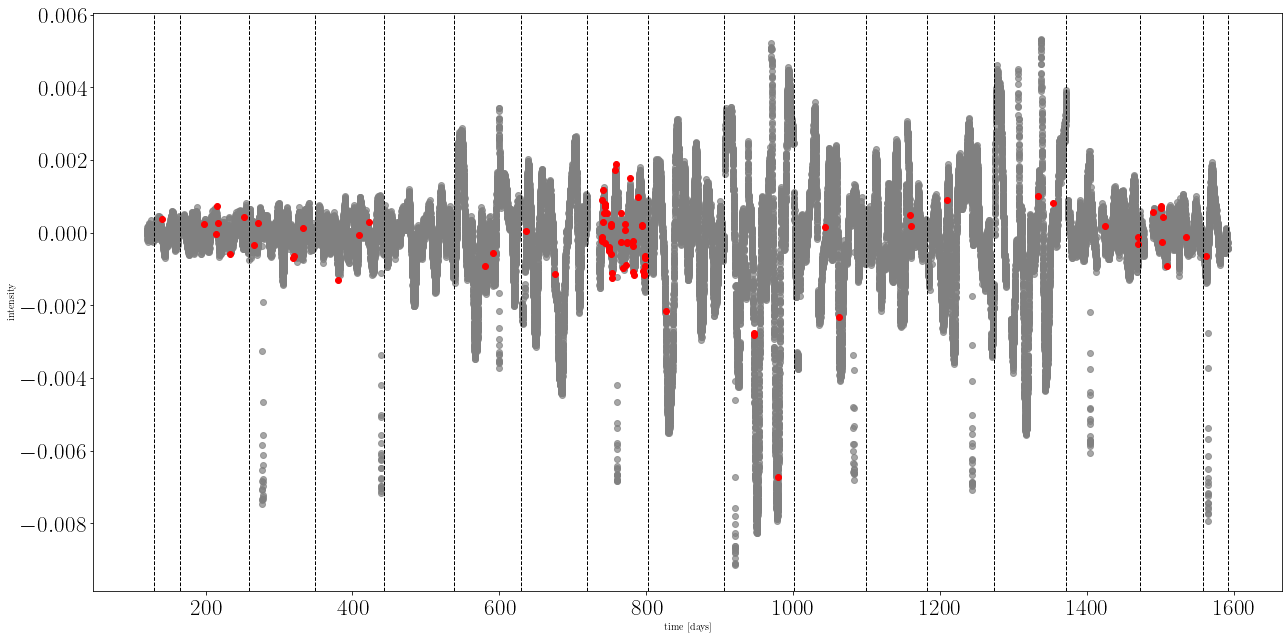

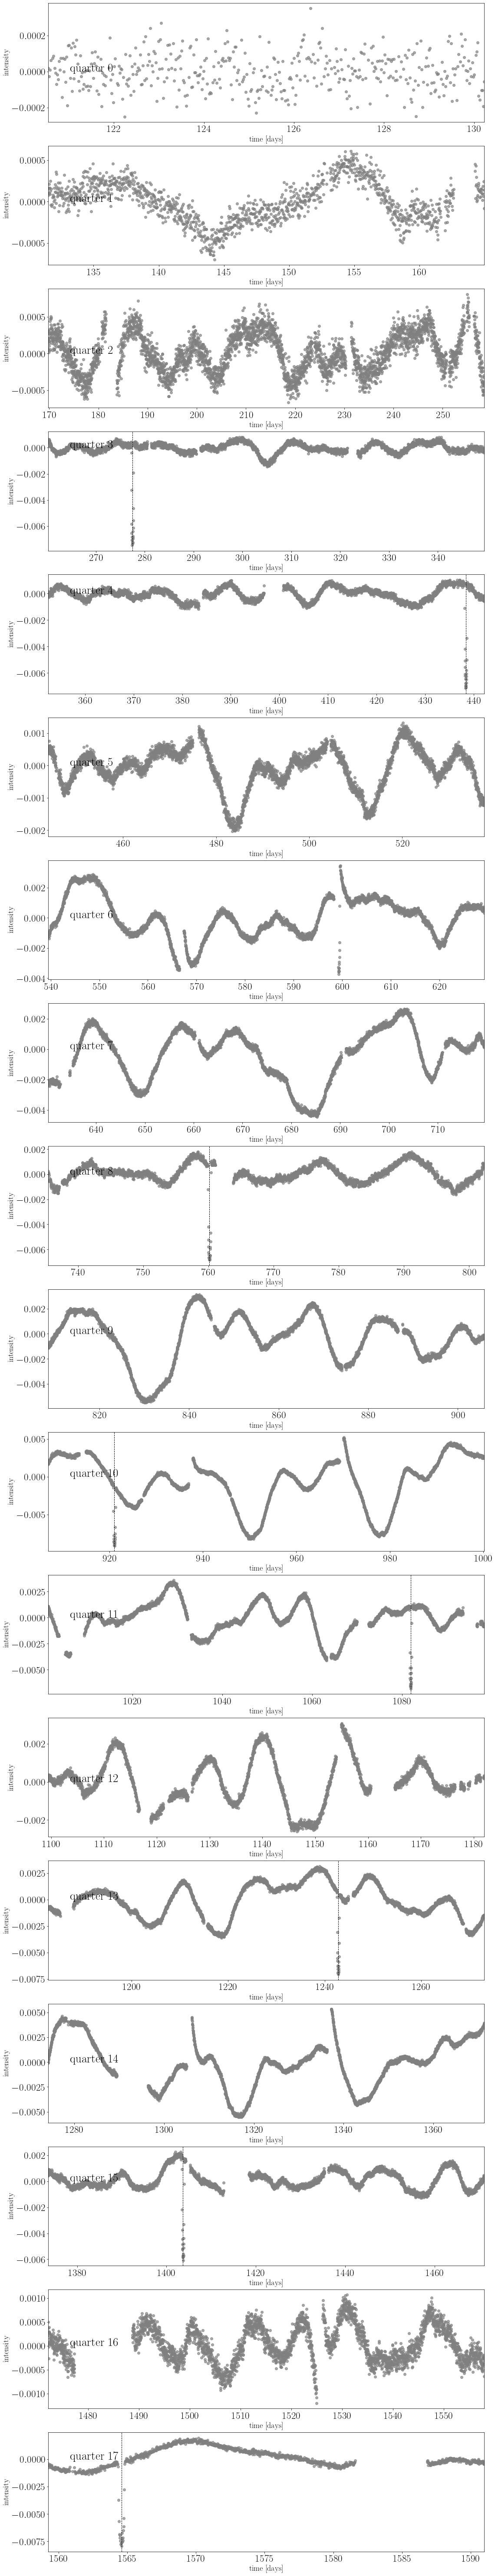

In [51]:
#kepler 1513 = koi-3678
#kepler 1519 = koi-3762
pdc_time, pdc_lc, pdc_lc_err, pdc_mask, \
t0s_bad, period, duration, kepler_quarters, crowding, flux_fraction  = \
get_light_curve('koi-3678', 'pdcsap_flux', Kepler=True)

cadence = deteremine_cadence(pdc_time)
t0s = [ 277.504085,
       438.38873587,
       760.15803761,
       921.04268848,
       1081.92733935,
       1242.81199022,
       1403.69664109,
       1564.58129196]

kepler_quarters_end = [el[1] for el in kepler_quarters]

#time between data points = 0.02 days
#time window = 0.02*30= 0.6 days
%matplotlib inline
%matplotlib inline

pdc_time_out, pdc_flux_out, pdc_flux_err_out, pdc_mask_out, pdc_moving_median = \
reject_outliers_out_of_transit(pdc_time, pdc_lc, pdc_lc_err, pdc_mask, 30*cadence, 4)

plot_outliers(pdc_time, pdc_lc, pdc_time_out, pdc_flux_out, 
              pdc_moving_median, kepler_quarters_end)



x_quarters, y_quarters, yerr_quarters, mask_quarters = \
split_around_problems(pdc_time_out, pdc_flux_out, pdc_flux_err_out, 
                      pdc_mask_out, kepler_quarters_end)

plot_split_data(x_quarters, y_quarters, t0s)



x_transits, y_transits, yerr_transits, mask_transits = \
find_quarters_with_transits(x_quarters, y_quarters, yerr_quarters, mask_quarters, t0s)

local detrending
1 outliers
outlier times: [1564.6206309333065]


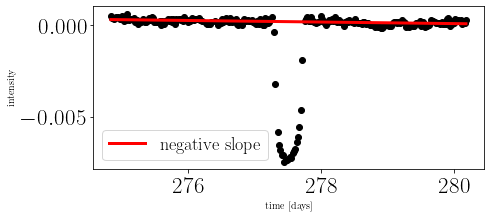

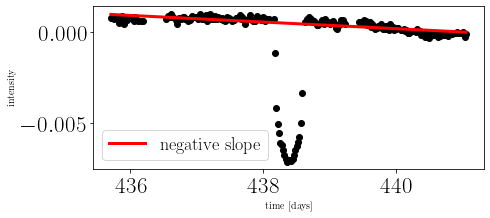

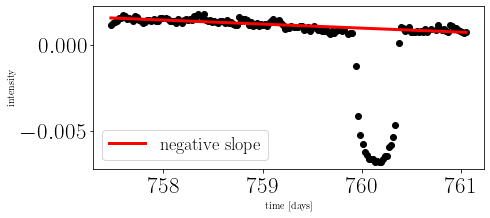

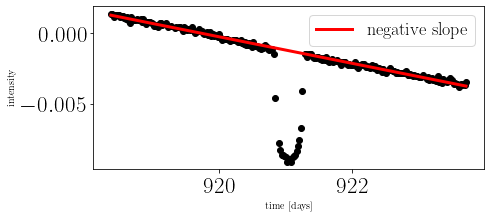

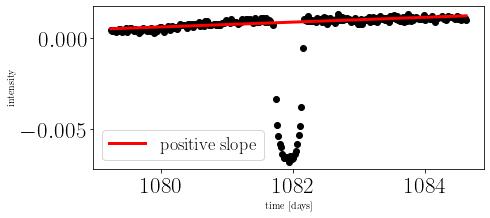

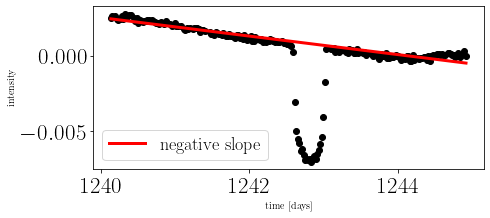

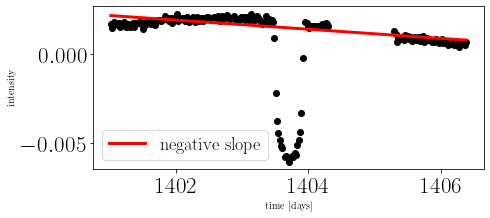

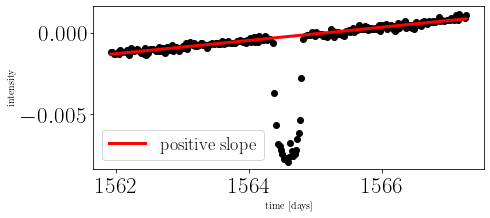

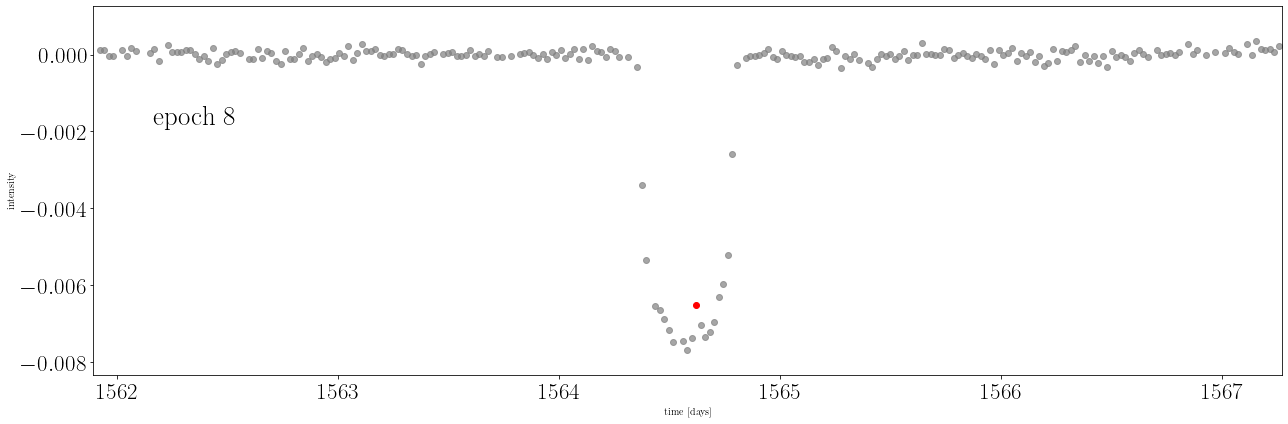

In [52]:



x_epochs = np.concatenate(x_transits, axis=0, dtype='float64')
y_epochs = np.concatenate(y_transits, axis=0, dtype='float64')
yerr_epochs = np.concatenate(yerr_transits, axis=0, dtype='float64')
mask_epochs = np.concatenate(mask_transits, axis=0, dtype=bool)


x_trimmed, y_trimmed, yerr_trimmed, mask_trimmed = \
trim_jump_times(x_epochs, y_epochs, yerr_epochs, mask_epochs, 
                t0s, period, [])


# determine local window values for later use
# zoom in around local window
pdc_local_x_epochs, pdc_local_y_epochs, pdc_local_yerr_epochs, pdc_local_mask_epochs = \
split_around_transits(np.concatenate(x_trimmed, axis=0, dtype='float64'), 
                      np.concatenate(y_trimmed, axis=0, dtype='float64'),
                      np.concatenate(yerr_trimmed, axis=0, dtype='float64'),
                      np.concatenate(mask_trimmed, axis=0, dtype=bool),
                      t0s, float(6*duration/(24.))/period, period)


pdc_local_x = np.concatenate(pdc_local_x_epochs, axis=0, dtype='float64')
pdc_local_y = np.concatenate(pdc_local_y_epochs, axis=0, dtype='float64')
pdc_local_yerr = np.concatenate(pdc_local_yerr_epochs, axis=0, dtype='float64')
pdc_local_mask = np.concatenate(pdc_local_mask_epochs, axis=0, dtype=bool)


###################
###################
###################
# local detrending
print('local detrending')
pdc_local_detrended, pdc_slopes = \
local_method(pdc_local_x_epochs, pdc_local_y_epochs, pdc_local_yerr_epochs, pdc_local_mask_epochs, 
             t0s, duration, period)

# remove outliers in unmasked local detrended lc
pdc_local_x_no_outliers, pdc_local_detrended_no_outliers = \
reject_outliers_everywhere(pdc_local_x, pdc_local_detrended, pdc_local_yerr, 5*cadence, 5, 5)

plot_individual_outliers(pdc_local_x, pdc_local_detrended, pdc_local_x_no_outliers, pdc_local_detrended_no_outliers,
                         t0s, period, float(6*duration/(24.))/period, 0.009)





local detrending


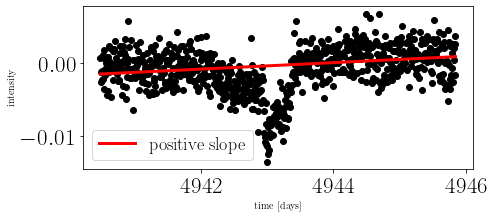

In [53]:
import pandas as pd

TESS = pd.read_csv('TESS_koi3678.csv')
x_TESS = TESS['time [BJD]']-2454833
y_TESS = TESS['flux']
yerr_TESS = TESS['flux_err']


transit_time = t0s[0]


transit_found = False
while not transit_found:
    if transit_time < 2459774-2454833:
        transit_time += period[0]
    
    else:
        transit_found = True
        
        
mask_TESS = []
for ii in range(0, len(x_TESS)):
    if x_TESS[ii] < ( transit_time-(duration*1.1)/(24.*2.) ):
        mask_TESS.append(False)
    elif x_TESS[ii] > ( transit_time+(duration*1.1)/(24.*2.) ):
        mask_TESS.append(False)
    else:
        mask_TESS.append(True)
        
mask_TESS = np.array(mask_TESS, dtype=bool)
#print(~mask_TESS)


import warnings
warnings.simplefilter('ignore', np.RankWarning)

x_local, y_local, yerr_local, mask_local = \
split_around_transits(x_TESS.values, y_TESS.values, yerr_TESS.values, mask_TESS, 
                      [transit_time], float(6*duration/(24.))/period, period)



x = np.array(x_local).astype(float)
y = np.array(y_local).astype(float)
yerr = np.array(yerr_local).astype(float)
mask = np.array(mask_local).astype(bool)

texp = np.median(np.diff(x))



###################
###################
###################
# local detrending
print('local detrending')
TESS_local_detrended, tess_slopes = \
local_method(x, y, yerr, mask, [transit_time], duration, period)




In [54]:
pdc_binary_slopes = []
for slope in pdc_slopes:
    if slope > 0:
        pdc_binary_slopes.append(1)
    else:
        pdc_binary_slopes.append(-1)
        
        
tess_binary_slopes = []
for slope in tess_slopes:
    if slope > 0:
        tess_binary_slopes.append(1)
    else:
        tess_binary_slopes.append(-1)
        

In [55]:
binary_slopes = pdc_binary_slopes+tess_binary_slopes
slopes_all = pdc_slopes + tess_slopes


In [56]:
import pandas as pd
from matplotlib.lines import Line2D
plt.rc('font', family='serif')


ttvs_df = pd.read_csv('times_input.txt', sep='\t')

epochs = ttvs_df['epoch']
times = ttvs_df['time']
times_err = ttvs_df['time_err']

koi3678_period = 160.883840387890871
koi3678_t0 = 277+0.506160949430603635


linear_ephemeris = []
for epoch in epochs:
    linear_ephemeris.append(koi3678_t0+(epoch*koi3678_period))


ttvs=[]
for ii in range(0, len(epochs)):
    ttvs.append((times[ii]-linear_ephemeris[ii])*24*60)

        
        


marker_colors = []
for ii in range(0, len(ttvs)):
    marker_colors.append('k')
    
    

    

ttv_plot = []
for ttv in ttvs:
    if ttv>0:
        ttv_plot.append(1)
        
    else:
        ttv_plot.append(-1)
        


/var/folders/9z/bcj7jltn3x5_8y20r9cxql3h0000gn/T/ipykernel_67691/2298410533.py:43: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


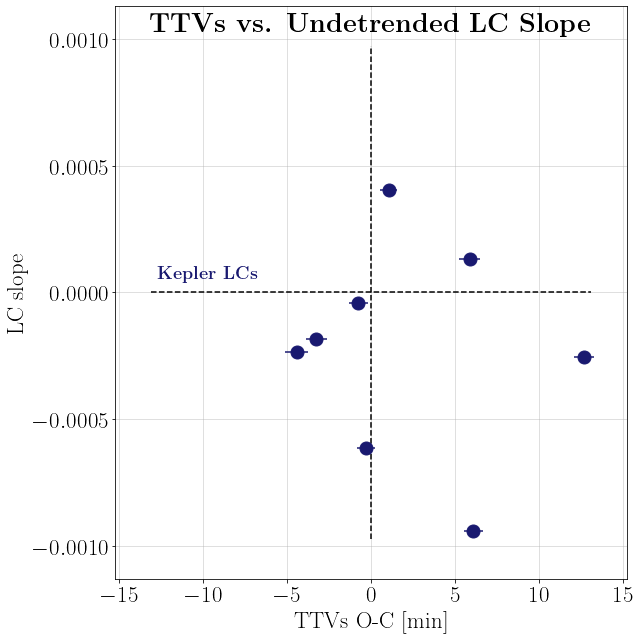

In [91]:



fig, ax = plt.subplots(figsize = [9, 9])

plt.grid(visible=True, alpha=0.5)
min_x, max_x = np.abs(np.min(ttvs[:-1])), np.max(ttvs[:-1])
if min_x>max_x:
    x_range=min_x*1.2
else:
    x_range=max_x*1.2
    
min_y, max_y = np.abs(np.min(slopes_all[:-1])), np.max(slopes_all[:-1])
if min_y>max_y:
    y_range=min_y*1.2
else:
    y_range=max_y*1.2




ax.errorbar(ttvs[:-1], slopes_all[:-1], xerr=times_err[:-1]*24.*60., color = '#191970', marker = 'o', ls='', ms=13)

ax.set_xlabel('TTVs O-C [min]', fontsize = 23)
ax.set_ylabel('LC slope', fontsize = 23)

ax.axhline(0,.07,.93,color='k',ls='--')
ax.axvline(0,.07,.93,color='k',ls='--')

ax.set_xlim(-x_range, x_range)
ax.set_ylim(-y_range, y_range)

ax.annotate(r"\textbf{Kepler LCs}", xy=(0.18, 0.5), weight='bold',
            xycoords="axes fraction", xytext=(0, 10), fontsize=18,
            textcoords="offset pixels", ha="center", va="bottom", color='#191970')

ax.annotate(r"\textbf{TTVs vs. Undetrended LC Slope}", xy=(0.5, .93), weight='bold',
            xycoords="axes fraction", xytext=(0, 10), fontsize=27,
            textcoords="offset pixels", ha="center", va="bottom")

fig.tight_layout()


fig.savefig('starspot_ttvs_kepler.pdf')

fig.show()








/var/folders/9z/bcj7jltn3x5_8y20r9cxql3h0000gn/T/ipykernel_67691/371776755.py:44: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


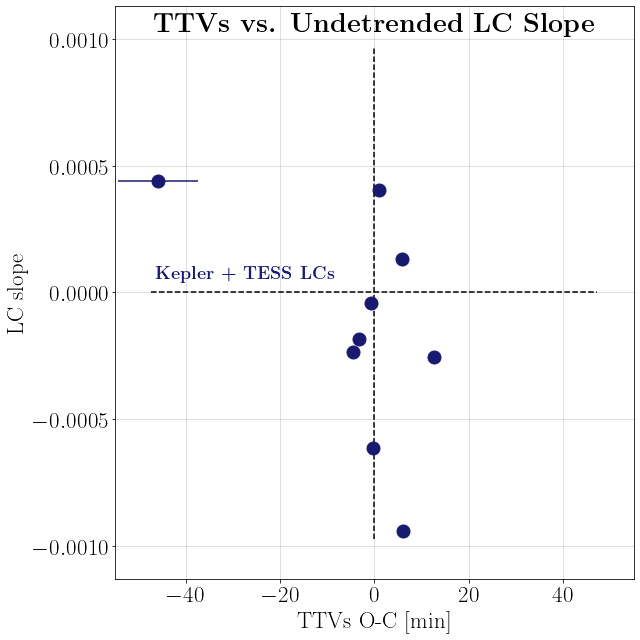

In [92]:




fig, ax = plt.subplots(figsize = [9, 9])

plt.grid(visible=True, alpha=0.5)
min_x, max_x = np.abs(np.min(ttvs)), np.max(ttvs)
if min_x>max_x:
    x_range=min_x*1.2
else:
    x_range=max_x*1.2
    
min_y, max_y = np.abs(np.min(slopes_all)), np.max(slopes_all)
if min_y>max_y:
    y_range=min_y*1.2
else:
    y_range=max_y*1.2





ax.errorbar(ttvs, slopes_all, xerr=times_err*24.*60., color = '#191970', marker = 'o', ls='', ms=13)

ax.set_xlabel('TTVs O-C [min]', fontsize = 23)
ax.set_ylabel('LC slope', fontsize = 23)

ax.axhline(0,.07,.93,color='k',ls='--')
ax.axvline(0,.07,.93,color='k',ls='--')

ax.set_xlim(-x_range, x_range)
ax.set_ylim(-y_range, y_range)

ax.annotate(r"\textbf{Kepler + TESS LCs}", xy=(0.25, 0.5), weight='bold',
            xycoords="axes fraction", xytext=(0, 10), fontsize=18,
            textcoords="offset pixels", ha="center", va="bottom", color='#191970')

ax.annotate(r"\textbf{TTVs vs. Undetrended LC Slope}", xy=(0.5, .93), weight='bold',
            xycoords="axes fraction", xytext=(0, 10), fontsize=27,
            textcoords="offset pixels", ha="center", va="bottom")

fig.tight_layout()


fig.savefig('starspot_ttvs.pdf')

fig.show()






